In [1]:
import os
from datetime import datetime,timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import shutil
import random
import requests
from bs4 import BeautifulSoup
import urllib
import matplotlib.dates as mdates

### Import Measured Data

In [2]:
def import_data(path,year): 
    """ 
    Import all data stated in the timeframe into dataframe.
    Data file format: {year} data.csv

    Return dataframe of imported data and list of dates in datetime format

    Parameter:
    path: path to folder containing the data csv file
    year: year of the data 
    """
    data = pd.read_csv(path+f'{year} data.csv')

    columns_name = {'DATE (MM/DD/YYYY)':'Date','Global CMP22 (vent/cor) [W/m^2]':'Measured GHI','Zenith Angle [degrees]':'Measured Zenith','Azimuth Angle [degrees]':'Measured Azimuth'}
    data = data.rename(columns = columns_name)

    data.insert(loc = 2, column = 'Datetime',value= data['Date']+' '+data['MST']) 
    data['Datetime'] = pd.to_datetime(data['Datetime'])

    dates = data['Date'].unique().tolist()
    dates = [datetime.strftime(datetime.strptime(x,'%m/%d/%Y'),'%Y%m%d') for x in dates]
    data = data[data["Measured GHI"] >= 0]
    
    return data,dates

def get_data(path,date,data):
    """
    Return a dataframe of merged data of the day.
    -Slice out measured data from the dataframe containing all the data and merge
    with the available image.
    -Only can be used when the images of the day is in the path.
    
    Parameters:
    path: path to the measured data
    date: date of the measured data
    data: dataframe containing all the measured data
    """
    img_path = path+date
    imgs = pd.DataFrame({'Image path':os.listdir(img_path)})
    raw = imgs[imgs['Image path'].str.endswith('_11.jpg')]
    raw = raw.copy()

    raw.loc[:,'Datetime'] = pd.to_datetime(raw['Image path'].str[:14], format = '%Y%m%d%H%M%S')
    raw['Datetime'] = pd.to_datetime(raw['Datetime']).dt.strftime('%Y-%m-%d %H:%M')
    data['Datetime'] = pd.to_datetime(data['Datetime']).dt.strftime('%Y-%m-%d %H:%M')
    merged_raw = pd.merge(data,raw, on = 'Datetime', how ='inner')
    merged_raw['Datetime'] = pd.to_datetime(merged_raw['Datetime'])
    
    return merged_raw

In [3]:
def get_latest_date(csv_files):
    latest_date = None
    for csv_file in csv_files:
        date_str = csv_file.split(".")[0]  # Extract the date part
        date = datetime.strptime(date_str, "%Y%m%d").date()
        if date and (latest_date is None or date > latest_date):
            latest_date = date
    return latest_date

get_latest_date([
    "20230901.csv",
    "20230903.csv",
    "20230831.csv",
])


datetime.date(2023, 9, 3)

### Image Download and Image Segmentation Functions

#### Image download function

In [4]:
def extract_img(year,month,day,hour,minute):
    """
    Dowload images from NREL webpage. Raise NO_IMG flag is no image at that time.
    Return downloaded image.

    Parameter:
    year,month,day,hour,minute: datetime of the downloading image.
    """
    # URL of the webpage containing images
    url = f"https://midcdmz.nrel.gov/apps/imagerdata.pl?site=SRRLASI;year={year};month={month};day={day};hour={hour};min={minute};rtype=0;ptype=5"

    # Send an HTTP GET request
    response = requests.get(url)

    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all image tags
        img_tags = soup.find_all('img')

        # Extract image URLs and download them
        img_url = img_tags[0]['src']
        ext_idx = img_url.index('ext=')+4
        img_url_ext = img_url[ext_idx:ext_idx+4]
        if img_url_ext == '1112':
            # Construct the full image URL if it's relative
            if not img_url.startswith('http'):
                img_url = urllib.parse.urljoin(url, img_url)

            # Download the image
            img_data = requests.get(img_url).content
            return img_data
        
        else:
            global NO_IMG
            NO_IMG = True        
    else:
        print(f"Failed to fetch the webpage for {month},{day},{hour},{minute}")

def create_folder(name,directory_path):
    """
    Create folder if folder does not exists.
    Return: newly created folder path

    Parameter:
    name: folder name
    path: path containing the folder
    """
    folder_path = directory_path+name
    # Check if the folder already exists
    if not os.path.exists(folder_path):
        # If it doesn't exist, create the folder
        os.makedirs(folder_path)
        print(f"Folder '{name}' has been created.")

    return folder_path

##### Radius Function (ROI Extraction)

In [5]:
def mask_circular_roi(image, PLOT_IMG = False):
    """
    Find radius of the ROI and mask out the ROI.
    Return masked image and pixel coordinates of ROI.
    Radius will be updated to main directly.

    Parameters:
    image: raw image
    PLOT_IMG: flag to indicate plotting of masked image.(used for checking the result image)
    """
    global radius
    row,col,_ = image.shape
    center = (int(col/2), int(row/2))

    if radius == 0:
        edge = 0
        for i,pix in enumerate(image[center[1],:,:]):
            if pix[0] > 10 and pix[1] > 10 and pix[2] > 10:
                edge = i
                break 
        radius = center[0] - edge - 10
    
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    non_zero_coords = np.transpose(np.nonzero(np.all(masked_image != [0, 0, 0], axis=-1)))
    
    if PLOT_IMG:
        plt.figure(figsize=(15,7.5))
        plt.subplot(1, 1, 1)
        plt.title('Cropped ROI image')
        plt.imshow(cv2.cvtColor(masked_image,cv2.COLOR_BGR2RGB))

    return masked_image,non_zero_coords

#### Sun Position Function

In [6]:
def distance(x1,y1,x2,y2):
    'To compute distance between points.'
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def segment_sun_position(img, PLOT_SUN = False):
    '''
    Return segmented sun coordinates. 
    Raise NO_SUN and return nan coordinates if no sun is detected. 
    -Locate sun position using image segmentation. 
    -Sky images are thresholded with R-channel value of 240.
    -The center of the largest contour are determined as the center of the sun.
    
    Parameter:
    img: sky image
    PLOT_SUN: flag to plot result image
    '''
    global NO_SUN
    threshold = 240
    R = img[:,:,2]
    _,sun = cv2.threshold(R,threshold,255,cv2.THRESH_BINARY)

    if not (sun!=0).sum() == 0: #masked probable sun position
        contours, _ = cv2.findContours(sun, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key= cv2.contourArea)
        largest_area = cv2.contourArea(largest_contour)
        moments = cv2.moments(largest_contour)

        if (largest_area >= 5000) and (moments['m00'] != 0): # only compute sun area larger than 500
            centroid_x = int(moments["m10"] / moments["m00"])
            centroid_y = int(moments["m01"] / moments["m00"])
            NO_SUN = False

            if PLOT_SUN:
                c_img = img.copy()
                cv2.circle(c_img,(centroid_x,centroid_y),5,(0,0,255),-1)
                cv2.drawContours(c_img,[largest_contour],-1, (0, 255, 0), 2)
                plt.figure(figsize=(15,7.5))
                plt.subplot(1, 1, 1)
                plt.imshow(cv2.cvtColor(c_img,cv2.COLOR_BGR2RGB))
                plt.title('Segmented Sun Position')
        
            return (centroid_x,centroid_y)
        
        else:
            NO_SUN = True
            return (np.nan,np.nan)
    
    else:
        NO_SUN = True
        return (np.nan,np.nan)

def img_sun_location(img,zenith,azimuth):
    """
    Return calculated and segmented x,y sun postion.
    -Compute sun center using calculation and image segmentation method.
    -Calculated sun center is used to ensure the correctness of segmented sun.
    -Segmented sun is the actual sun position only if 
    the distance between calculated and segmented sun does not exceed 200 unit pixels.

    Parameters:
    img: sky image.
    zenith: measured solar zenith angle.
    azimuth: measured solar azimuth angle.
    """
    global radius
    global NO_SUN
    width,height,_ = img.shape

    sun_x,sun_y = segment_sun_position(img) 

    #sun position formula using elevation angle and azimuth angle
    elevation = 90 - zenith
    center = (int(height/2), int(width/2))
    cal_sun_x = center[0] - radius*np.sin(np.radians(azimuth))*np.cos(np.radians(elevation))
    cal_sun_y = center[1] - radius*np.cos(np.radians(azimuth))*np.cos(np.radians(elevation))
    
    dist = distance(sun_x,sun_y,cal_sun_x,cal_sun_y)
    
    if dist >200 or NO_SUN:
        NO_SUN = True
        sun_x = np.nan
        sun_y = np.nan

    else:
        NO_SUN = False

    return cal_sun_x,cal_sun_y,sun_x,sun_y

def plot_sun(img,sun_x,sun_y,dt,display = 'PLT'):
    """
    Plot sky images with sun center point. Used for observing result.
    
    Parameters:
    img: Sky image.
    sun_x,sun_y: coordinates of the actual sun.
    dt: datetime
    display:'PLT'(default) - plot in output
            'Windows'- plot in windows
            'Save'- save to folder 
    """
    date = datetime.strftime(dt,'%Y%m%d')
    plt.figure(figsize=(15,7.5))
    plt.subplot(1, 1, 1)

    try:
        if isinstance(sun_x, list) and isinstance(sun_y,list) and (len(sun_x) == len(sun_y)):
            plt.scatter(int(sun_x[0]),int(sun_y[0]), color='b', label ='Calculated Sun Position',s=10)
            plt.scatter(sun_x[1],sun_y[1],color='r',label='Actual Sun Position',s=10)

        elif isinstance(sun_x, float) and isinstance(sun_y,float):
            plt.scatter(int(sun_x),int(sun_y), color='b', label ='Calculated Sun Position',s=10)
        
        else:
            raise TypeError
        
    except TypeError:
        print('Sun x and Sun y must be the same list type or float type and have the same length.')

    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.legend()
    plt.title(f'Sun Position at {date}')


    #if display == 'Save':
    #    sun_path = path+date+'\\Sun plot'
    #    file_name = datetime.datetime.strftime(dt,'%Y%m%d%H%M%S')+'.jpg'
    #    if not os.path.exists(sun_path):
    #        os.makedirs(sun_path)
    #        print(f"Folder '{date}' has been created.")
        
    #    plt.savefig(os.path.join(sun_path, file_name))


##### Image Luminance Function

In [7]:
def whole_luminance(img,zenith,ANALYSE_RATIO_THICKNESS = False,PLOT_GLOBAL= False):
    """
    Return average luminance value and luminance image. 
    -Compute luminance of every RGB pixel. 
    **Cloud ratio and cloud thickness computation only for whole image.
    
    Parameters:
    img: sky image.
    zenith: solar zenith angle
    ANALYSE_RATIO_THICKNESS: flag to compute cloud ratio and thickness.
    PLOT_GLOBAL: flag to plot image with only
    """
    B = img[:,:,0]
    G = img[:,:,1]
    R = img[:,:,2]
    
    #Luminance value equation
    Y = 0.2126*R + 0.7152*G +0.0722*B
    roi_pix = (Y!=0).sum()
    norm_Y = Y/255
    Y = np.power(255*(Y/255),2.2)
    average = np.sum(Y)/((Y!=0).sum())
    Lr = abs(average*math.cos(math.radians(zenith)))
    
    if ANALYSE_RATIO_THICKNESS: 
        #cloud ratio and cloud thickness
        rb_max = np.maximum(R,B)
        rb_fix = np.empty(rb_max.shape)
        non_zero_rb = rb_max != 0
        rb_fix[non_zero_rb]= R[non_zero_rb]/rb_max[non_zero_rb]
        rb_fix[rb_max == 0] = 0

        CM_global = np.where((norm_Y>0.9)|(norm_Y < 0.01), 0, rb_fix)
        binary = np.where(CM_global > 0.9, 1, 0)
        ratio = np.count_nonzero(binary)/roi_pix    
        thickness = np.sum(np.where(binary != 0, CM_global, 0))/np.count_nonzero(binary)
        #print('Cloud Ratio: ', ratio)
        #print('Cloud Thickness: ', thickness)
        
        if PLOT_GLOBAL:
            fig2, ax2 = plt.subplots(1,3,figsize=(15,7.5))
            
            ax2[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2[0].set_title('Original image')
            ax2[0].text(0.5,-0.2,'(a)',size = '12',ha= 'center',transform =ax2[0].transAxes)
            
            im1 = ax2[1].imshow(CM_global, cmap='viridis')
            ax2[1].set_title('Global Cloud Map')
            fig2.colorbar(im1, ax=ax2[1],shrink = 0.5)
            ax2[1].text(0.5,-0.2,'(b)',size = '12',ha= 'center',transform =ax2[1].transAxes)
            
            ax2[2].imshow(binary, cmap='gray')
            ax2[2].set_title('Binary')
            ax2[2].text(0.5,-0.2,'(c)',size = '12',ha= 'center',transform =ax2[2].transAxes)
            
            plt.show()
        return Lr, ratio, thickness, Y
        
    else:
        return Lr,Y
        
def random_sampling_whole(luminance,zenith,non_zero_coords, sampling_points = 1000):
    """
    Random sampling of luminance from whole luminance image.
    Return average whole image sampled luminance and coordinates of all sample points

    Parameters:
    luminance: luminance image.
    zenith: solar zenith angle.
    non_zero_coords: ROI coordinates.
    sampling_points: number of sampling points. (default=1000)
    """
    random_indices = np.random.choice(len(non_zero_coords), sampling_points, replace=False)
    random_coords = non_zero_coords[random_indices]
    sam_lum = luminance[random_coords[:,1],random_coords[:,0]]
    Lr_sam = np.sum(sam_lum)/(len(sam_lum))
    Lr_sam = abs(Lr_sam*math.cos(math.radians(zenith)))
    return Lr_sam,random_coords

def crop_sun_img(img,sun_x,sun_y,crop_dim=500, PLOT_IMG=False):
    """
    Return cropped image center based on sun center.

    Parameter: 
    img: sky image.
    sun_x, sun_y: coordinates of sun
    crop_dim: size of the cropped image.(default = 500x500 pixels)
    PLOT_IMG: flag to plot result image.(for observing result)
    """
    height,width,_ = img.shape
    
    sun_x = int(sun_x)
    sun_y = int(sun_y)
    x1 = np.maximum((sun_x - crop_dim//2),0)
    x2 = np.minimum((x1 + crop_dim),width)
    y1 = np.maximum((sun_y - crop_dim//2),0)
    y2 = np.minimum((y1 + crop_dim),height)

    around_sun = img[y1:y2,x1:x2]

    if PLOT_IMG:
        c_img = img.copy()
        cv2.rectangle(c_img, (x1, y1), (x2, y2), (0, 0, 255), 5)
        cv2.circle(c_img,(int(sun_x),int(sun_y)),5,(0,0,255),-1)
        plt.imshow(cv2.cvtColor(c_img,cv2.COLOR_BGR2RGB))
        
    return around_sun

def random_sampling_crop(crop_lum,zenith, sampling_points = 1000):
    """
    Random sampling of luminance from cropped luminance image.
    Return average cropped image sampled luminance and sampling points

    Parameters:
    luminance: cropped luminance image.
    zenith: solar zenith angle.
    sampling_points: number of sampling points. (default=1000)
    """
    non_zero_indices = np.transpose(np.nonzero(crop_lum))
    selected_indices = random.sample(list(non_zero_indices), np.minimum(sampling_points, len(non_zero_indices)))
    sam_lum = [crop_lum[y, x] for y, x in selected_indices]

    Lr_sam = sum(sam_lum)/(len(sam_lum))
    #Lr_sam = Lr_sam*(f**2)/exp
    Lr_sam = abs(Lr_sam*math.cos(math.radians(zenith)))
    return Lr_sam, selected_indices

### Functions Results


In [8]:
path = "C:\\Users\\Jia Jun\\Desktop\\FYP reference\\MIDC dataset\\automate download\\monthly\\"
data,dates = import_data(path,2023)
data

Date    MST            Datetime  Measured GHI  Measured Zenith  \
0        1/1/2023  07:25 2023-01-01 07:25:00      3.381440         89.86571   
1        1/1/2023  07:26 2023-01-01 07:26:00      3.741990         89.72116   
2        1/1/2023  07:27 2023-01-01 07:27:00      4.157970         89.57577   
3        1/1/2023  07:28 2023-01-01 07:28:00      4.638590         89.42948   
4        1/1/2023  07:29 2023-01-01 07:29:00      5.299970         89.28228   
...           ...    ...                 ...           ...              ...   
195233  9/10/2023  18:02 2023-09-10 18:02:00      0.205531         87.60752   
195234  9/10/2023  18:03 2023-09-10 18:03:00      0.159364         87.78932   
195235  9/10/2023  18:04 2023-09-10 18:04:00      0.109898         87.97030   
195236  9/10/2023  18:05 2023-09-10 18:05:00      0.098539         88.15038   
195237  9/10/2023  18:06 2023-09-10 18:06:00      0.032123         88.32948   

        Measured Azimuth  
0              120.23922  
1              120.39859  
2              120.55824  
3              120.71818  
4              120.87840  
...                  ...  
195233         274.33561  
195234         274.49475  
195235         274.65391  
195236         274.81312  
195237         274.97236  

[195019 rows x 6 columns]

In [9]:
day_data = get_data(path,'20230702',data)
day_data


Date    MST            Datetime  Measured GHI  Measured Zenith  \
0   7/2/2023  04:40 2023-07-02 04:40:00       4.25875         89.88436   
1   7/2/2023  04:50 2023-07-02 04:50:00      15.05700         88.38829   
2   7/2/2023  05:00 2023-07-02 05:00:00      22.73760         86.78683   
3   7/2/2023  05:10 2023-07-02 05:10:00      51.44210         85.12281   
4   7/2/2023  05:20 2023-07-02 05:20:00      75.47430         83.41759   
..       ...    ...                 ...           ...              ...   
84  7/2/2023  18:50 2023-07-02 18:50:00      32.28380         83.50674   
85  7/2/2023  19:00 2023-07-02 19:00:00      29.15600         85.21163   
86  7/2/2023  19:10 2023-07-02 19:10:00      17.15790         86.87458   
87  7/2/2023  19:20 2023-07-02 19:20:00      13.94050         88.47326   
88  7/2/2023  19:30 2023-07-02 19:30:00       5.74340         89.96391   

    Measured Azimuth             Image path  
0           59.09942  20230702044000_11.jpg  
1           60.68954  20230702045000_11.jpg  
2           62.25321  20230702050000_11.jpg  
3           63.79269  20230702051000_11.jpg  
4           65.31028  20230702052000_11.jpg  
..               ...                    ...  
84         294.71098  20230702185000_11.jpg  
85         296.22902  20230702190000_11.jpg  
86         297.76907  20230702191000_11.jpg  
87         299.33340  20230702192000_11.jpg  
88         300.92430  20230702193000_11.jpg  

[89 rows x 7 columns]

Radius = 758


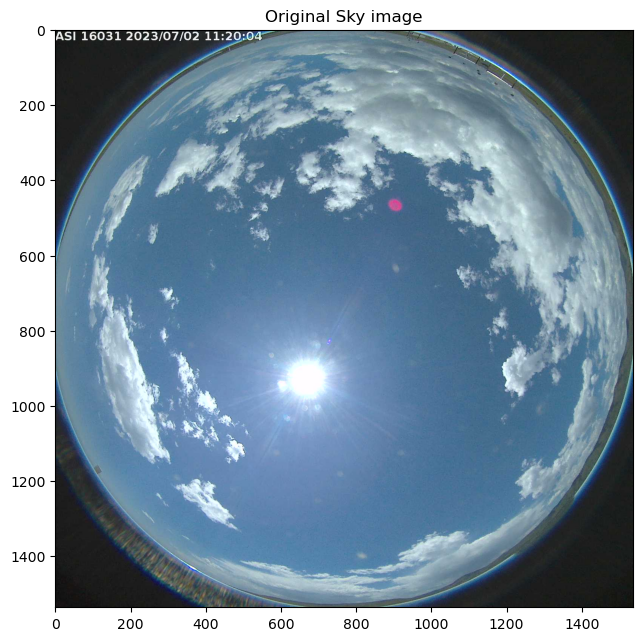

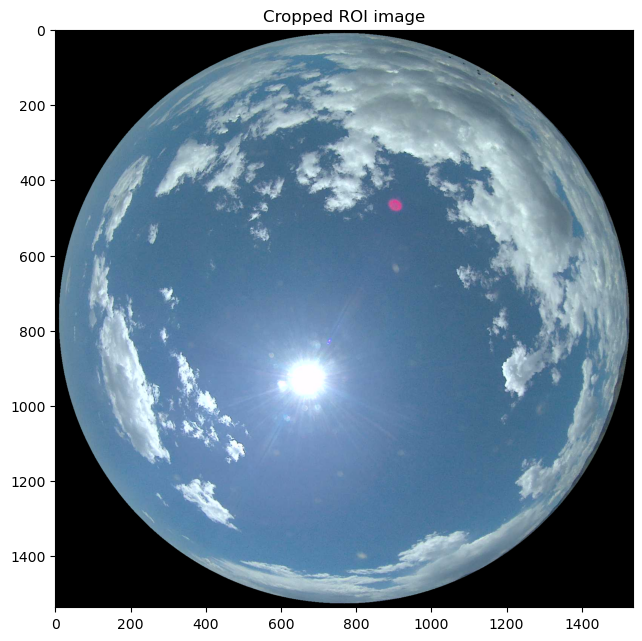

In [10]:
radius = 0
NO_SUN = True
x = 40
img = cv2.imread(path + '20230702' + '\\'+ str(day_data['Image path'][x]))
plt.figure(figsize=(15,7.5))
plt.subplot(1, 1, 1)
plt.title('Original Sky image')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

img, roi_coords = mask_circular_roi(img,1)
print('Radius =', radius)

(670, 930)

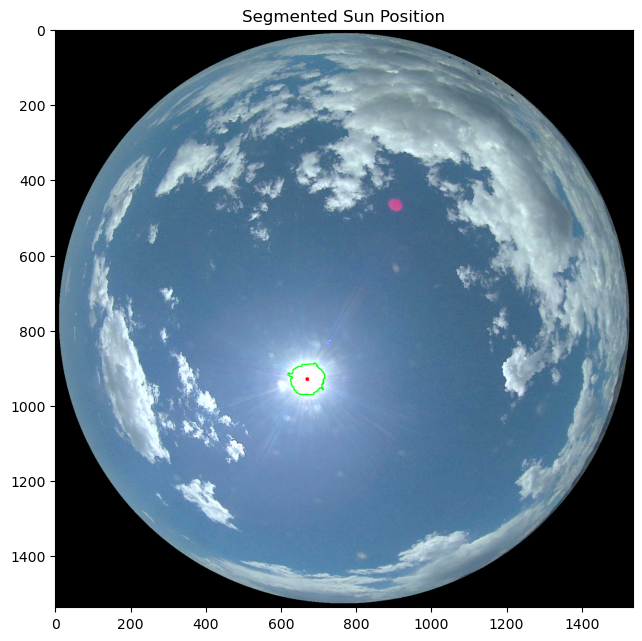

In [11]:
seg_x,seg_y = segment_sun_position(img,True)
seg_x,seg_y


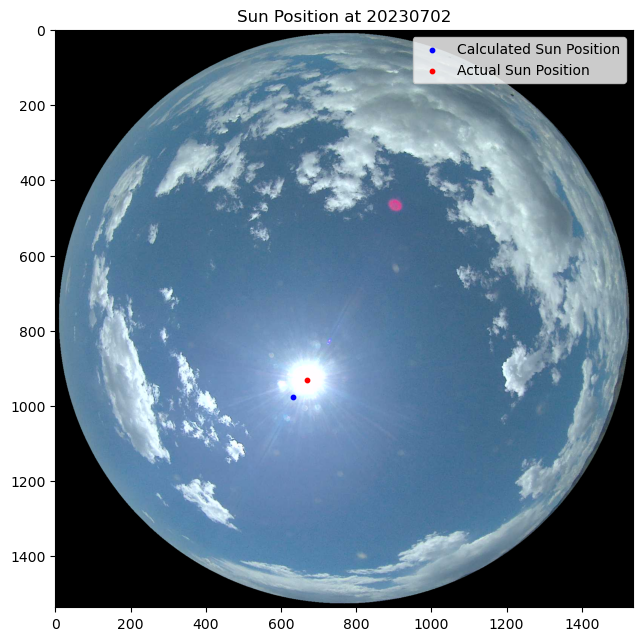

In [12]:
cal_x,cal_y,seg_x,seg_y = img_sun_location(img,day_data['Measured Zenith'][x],day_data['Measured Azimuth'][x])
plot_sun(img,[cal_x,seg_x],[cal_y,seg_y],day_data['Datetime'][x])

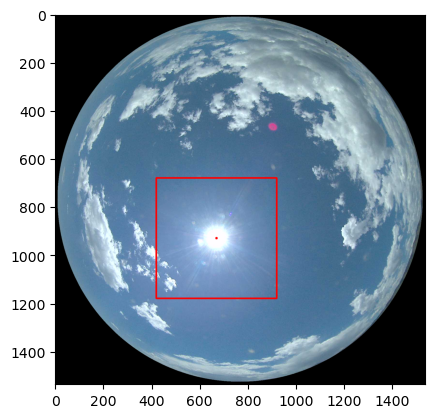

In [13]:
crop_img = crop_sun_img(img,seg_x,seg_y,PLOT_IMG = True)
#using segmented sun as center, red rectangular is the cropping area(500 pixels)

Text(0.5, 1.0, 'Cropped sun image')

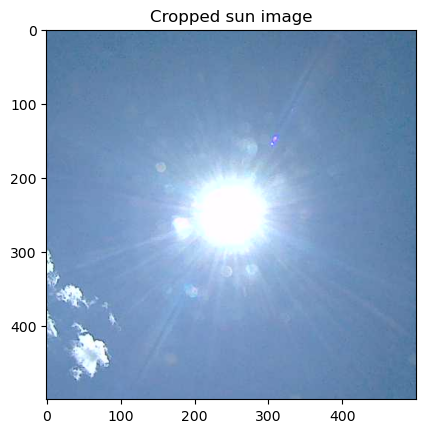

In [14]:
#resulting cropped image
plt.imshow(cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB))
plt.title('Cropped sun image')

50183.56328049962

50743.08655623345

59633.75899298173

59665.42035816465

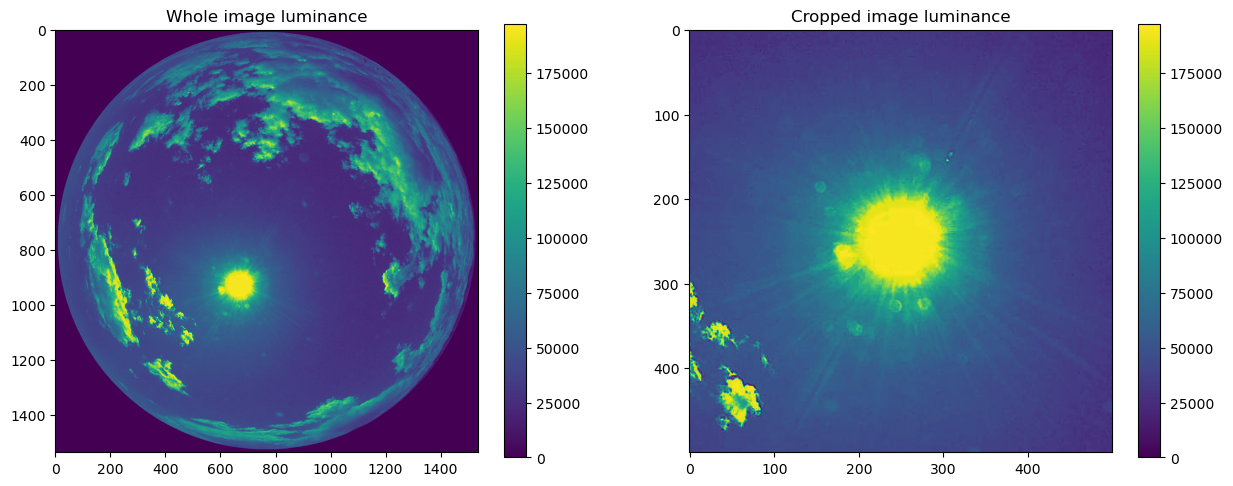

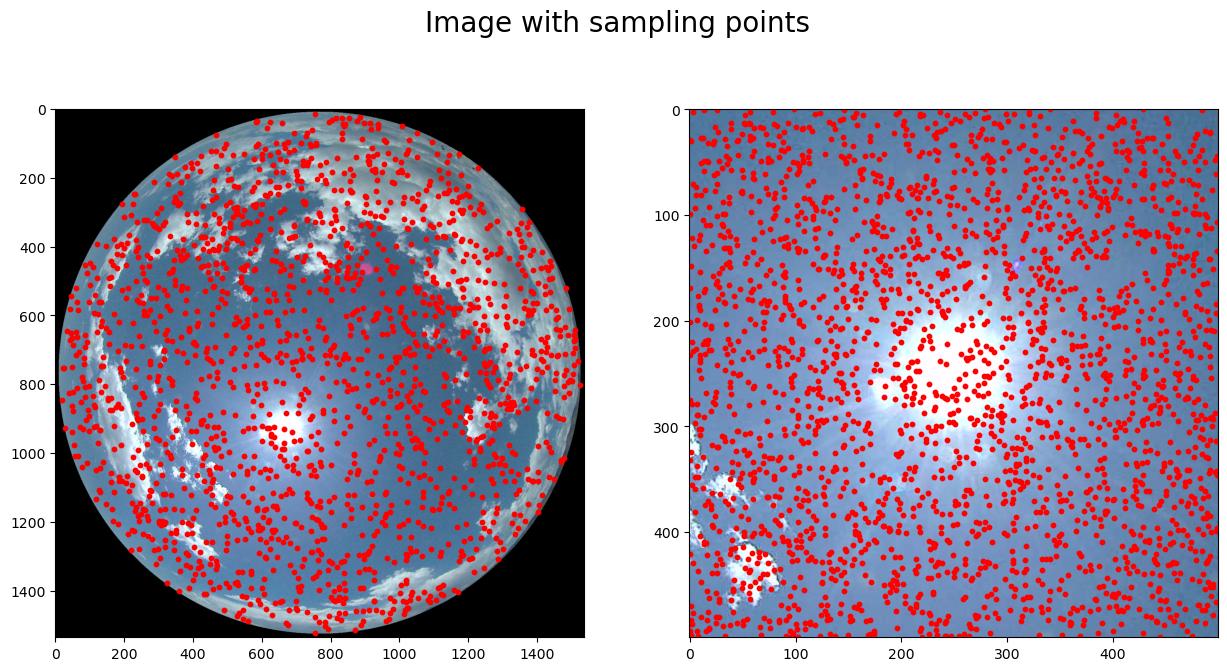

In [15]:
whole_Lr,lum = whole_luminance(img,day_data['Measured Zenith'][x])
whole_Lr_sam,w_sam = random_sampling_whole(lum,day_data['Measured Zenith'][x],roi_coords,sampling_points= int(len(roi_coords)*1/1000))
crop_Lr, crop_lum = whole_luminance(crop_img,day_data['Measured Zenith'][x])
crop_Lr_sam,c_sam = random_sampling_crop(crop_lum,day_data['Measured Zenith'][x],sampling_points = int(crop_lum.shape[0]*crop_lum.shape[1]*1/100)) 

display(whole_Lr,whole_Lr_sam,crop_Lr,crop_Lr_sam)

fig, ax = plt.subplots(1,2,figsize=(15,7.5))
im = ax[0].imshow(lum)
ax[0].set_title('Whole image luminance')
fig.colorbar(im, ax=ax[0],shrink = 0.75)
im1 = ax[1].imshow(crop_lum)
ax[1].set_title('Cropped image luminance')
fig.colorbar(im, ax=ax[1],shrink = 0.75)

fig1, ax1 = plt.subplots(1,2,figsize=(15,7.5))
fig1.suptitle('Image with sampling points',fontsize=20)
ax1[0].scatter([x for x,_ in w_sam],[y for _,y in w_sam],color='r',s=10)
ax1[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1[1].scatter([x for x,_ in c_sam],[y for _,y in c_sam],color='r',s=10)
ax1[1].imshow(cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB))

### Main Function
Apply on main data dataframe

In [25]:
def image_segment(row):
    """
    Main image segmentation function. To be apply into data dataframe using Dataframe.apply function.
    Return Series of calculated and segmented sun position, Whole image full and random sampled luminance and Partial image full and random sampled luminance
    """
    global radius
    global directory_path
    global NO_SUN
    zenith = row['Measured Zenith']
    azimuth = row['Measured Azimuth']
    date = datetime.strptime(row['Date'], '%m/%d/%Y')
    date = date.strftime('%Y%m%d')

    img = cv2.imread(directory_path + date + '\\'+ str(row['Image path']))
    img,non_zero_coords = mask_circular_roi(img)
    
    cal_sun_x,cal_sun_y,sun_x,sun_y = img_sun_location(img,zenith,azimuth)

    if NO_SUN: 
        #if sun is not detected in image, cropping based on calculated position
        crop_img = crop_sun_img(img,cal_sun_x,cal_sun_y)
    else: 
        #else based on segmented position
        crop_img = crop_sun_img(img, sun_x, sun_y)
    
    wLr,luminance = whole_luminance(img,zenith)
    wLr_sam,_ = random_sampling_whole(luminance,zenith,non_zero_coords,sampling_points= int(len(non_zero_coords)*1/100))
    cLr, crop_lum = whole_luminance(crop_img,zenith)
    cLr_sam,_ = random_sampling_crop(crop_lum,zenith,sampling_points = int(crop_lum.shape[0]*crop_lum.shape[1]*1/100)) 
    return pd.Series({'Sun x':sun_x,'Sun y':sun_y,'Cal x':cal_sun_x,'Cal y':cal_sun_y,'Whole Luminance':wLr,'Sampled Whole Luminance':wLr_sam,'Cropped Luminance':cLr,'Sampled Cropped Luminance':cLr_sam})


### Main Program
All the images are downloaded and processed day by day. The daily results will be saved in csv file and processed images will be deleted.

In [10]:
#Initialization
#can manipulate timeframe
start_date = datetime(2023,9,1)
end_date = datetime(2023,9,2)
day_interval = timedelta(days = 1)

#daytime hours 
start_hour = 4
start_min = 30
end_hour = 19
end_min = 30
current_date = start_date #initialize date

#main folder path
directory_path = "C:\\Users\\Jia Jun\\Desktop\\FYP reference\\MIDC dataset\\automate download\\monthly\\"

#initialize parameters 
month_results = pd.DataFrame()
radius = 0
NO_SUN = True

#Flag for setting download image only(False) or download & process(True)
DOWN_PROCESS = True

data,dates = import_data(directory_path,start_date.year)

In [26]:
print('Start downloading...')

try:
    while current_date.date() <= end_date.date():
        year = current_date.year
        month = current_date.month
        day = current_date.day
        date = str(current_date.strftime("%Y%m%d"))
        #create folder for each month
        monthly_folder = create_folder(f'{current_date.strftime("%Y%m")}',directory_path)
        
        if os.path.exists(monthly_folder+f'\\{date}.csv'):
            res = pd.read_csv(monthly_folder+f'\\{date}.csv')
            month_results = pd.concat([month_results,res],axis =0)
            current_date += day_interval
            print(f'{date} result already exists.')
            continue
        
        folder_path = create_folder(date,directory_path)
        #Download all images of the day
        for hour in range(start_hour,end_hour+1):
            if hour == start_hour:
                start = start_min
                end = 60

            elif hour == end_hour:
                start = 0
                end = end_min+1
        
            else:
                start = 0
                end = 60

            for minute in range(start,end,10):
                NO_IMG = False
                dt = datetime(year, month, day, hour, minute)
                dt = str(dt.strftime("%Y%m%d%H%M"))
                img_name = f'{dt}00_11.jpg'
                if not os.path.exists(folder_path+'\\'+img_name):
                    img_data = extract_img(year,month,day,hour,minute)

                    if not NO_IMG:
                        with open(folder_path+'\\'+img_name,'wb') as img_file:
                            img_file.write(img_data)
                    else:
                        continue
                else:
                    continue

        print(f'All sky images of {date} has been downloaded successfully.')
        
        #Process downloaded images and delete folder when done
        if DOWN_PROCESS:
            if len(os.listdir(folder_path)) == 0:
                print(f'{date} do not have images.')
            
            else:
                measure_data = get_data(directory_path,date,data)
                new_cols = measure_data.apply(image_segment,axis=1)
                day_result = measure_data[['Datetime','Measured GHI','Measured Zenith','Measured Azimuth']]
                day_result = pd.concat([day_result,new_cols],axis = 1)
                #month_results = pd.concat([month_results,day_result],axis=0)
                
                csv_path = monthly_folder+f'\\{date}.csv'
                day_result.to_csv(csv_path,index = False)
                print(f'Done {date} successfully.')
            
            try:
                shutil.rmtree(folder_path)
                print(f"Directory '{folder_path}' and its contents deleted successfully.")
            except OSError as e:
                print(f"Error deleting directory: {e}")
            
        current_date += day_interval

except (KeyboardInterrupt,ConnectionError) as e:
    print(f'Error: {e}')
    print(f'Process stopped at {date}')

Start downloading...
All sky images of 20230901 has been downloaded successfully.
Done 20230901 successfully.
Folder '20230902' has been created.
All sky images of 20230902 has been downloaded successfully.
Done 20230902 successfully.


### Generate Estimation Model
Analyse results and generate estimation model using generated csv files previously.

In [11]:
def read_result(directory_path,yearmonth:str):
    '''
    Read a month of results csv into dataframe. 
    Return results dataframe.

    Parameters:
    directory_path: path containing all results folder(named with yearmonth)
    yearmonth: year and month of the reading results in string(name of the folder)
    '''
    folder_path = directory_path+yearmonth
    results = pd.DataFrame()
    for file in os.listdir(folder_path):
        day_result = pd.read_csv(folder_path+"\\"+file)
        results = pd.concat([results,day_result],axis=0,ignore_index=True)
        results['Datetime'] = pd.to_datetime(results['Datetime'])

    results.to_csv(directory_path+'July.csv',index=False)

    return results

def generate_models(result,degree):
    '''
    Return lists of whole image full pixel model, whole image sample pixel model,
    crop image full pixel model and crop image sample pixel model with different order 

    Parameters:
    result: result dataframe
    degree: order of the estimation model
    ''' 
    w_models = []
    w_sampling_models = []
    c_models = []
    c_sampling_models = []

    for x in range(1,degree+1):
        w_coeff = np.polyfit(result["Whole Luminance"],result["Measured GHI"],x)
        w_model = np.poly1d(w_coeff)
        w_models.append(w_model)

        ws_coeff = np.polyfit(result["Sampled Whole Luminance"],result["Measured GHI"],x)
        ws_model = np.poly1d(ws_coeff)
        w_sampling_models.append(ws_model)

        c_coeff = np.polyfit(result["Cropped Luminance"],result["Measured GHI"],x)
        c_model = np.poly1d(c_coeff)
        c_models.append(c_model)

        cs_coeff = np.polyfit(result["Sampled Cropped Luminance"],result["Measured GHI"],x)
        cs_model = np.poly1d(cs_coeff)
        c_sampling_models.append(cs_model)

    return w_models,w_sampling_models, c_models, c_sampling_models

def plot_models(models,sample_models, lum, sam_lum, ghi,name,thick = 1):
    '''
    Plot models for full pixels and sampling pixels.

    Parameters:
    models: list of full pixels models 
    sample_models: list of sampling pixels models 
    lum: average full pixels luminance
    sam_lum: average sampling pixels luminance
    ghi: measured solar irradiance
    name: name of the figure
    thick = thickness of the scatter plot(default= 1)
    '''
    num = len(models)
    alphabet = ['a','b','c','d','e','f','g','h','i','j']
    fig, ax = plt.subplots(2,num,figsize=(num*5,8),gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

    for i in range(num):
        j=0
        w_model = models[i]
        ax[j,i].scatter(lum,ghi,s=thick,c = 'blue')
        if i == 0:
            ax[j,i].plot(lum,w_model(lum),c='red')

        else:
            polyline = np.linspace(lum.min(),lum.max(),100)
            ax[j,i].plot(polyline,w_model(polyline),c='red')

        ax[j,i].set_xlabel("Luminance")
        ax[j,i].set_title(f'({alphabet[i]}) Order {i+1} model')
        ax[j,i].set_ylabel('GHI')

        j+=1

        s_model =sample_models[i]
        ax[j,i].scatter(sam_lum,ghi,s=thick,c = 'blue')

        if i == 0:
            ax[j,i].plot(sam_lum,s_model(sam_lum),c='red')

        else:
            polyline = np.linspace(sam_lum.min(),sam_lum.max(),100)
            ax[j,i].plot(polyline,s_model(polyline),c='red')
    
        ax[j,i].set_xlabel(f"Sampling Luminance")
        ax[j,i].set_ylabel('GHI')
        ax[j,i].set_title(f'({alphabet[i+num]}) Order {i+1} model')

    fig.suptitle(f'Luminance-GHI for {name}',fontsize=16)
    plt.show()


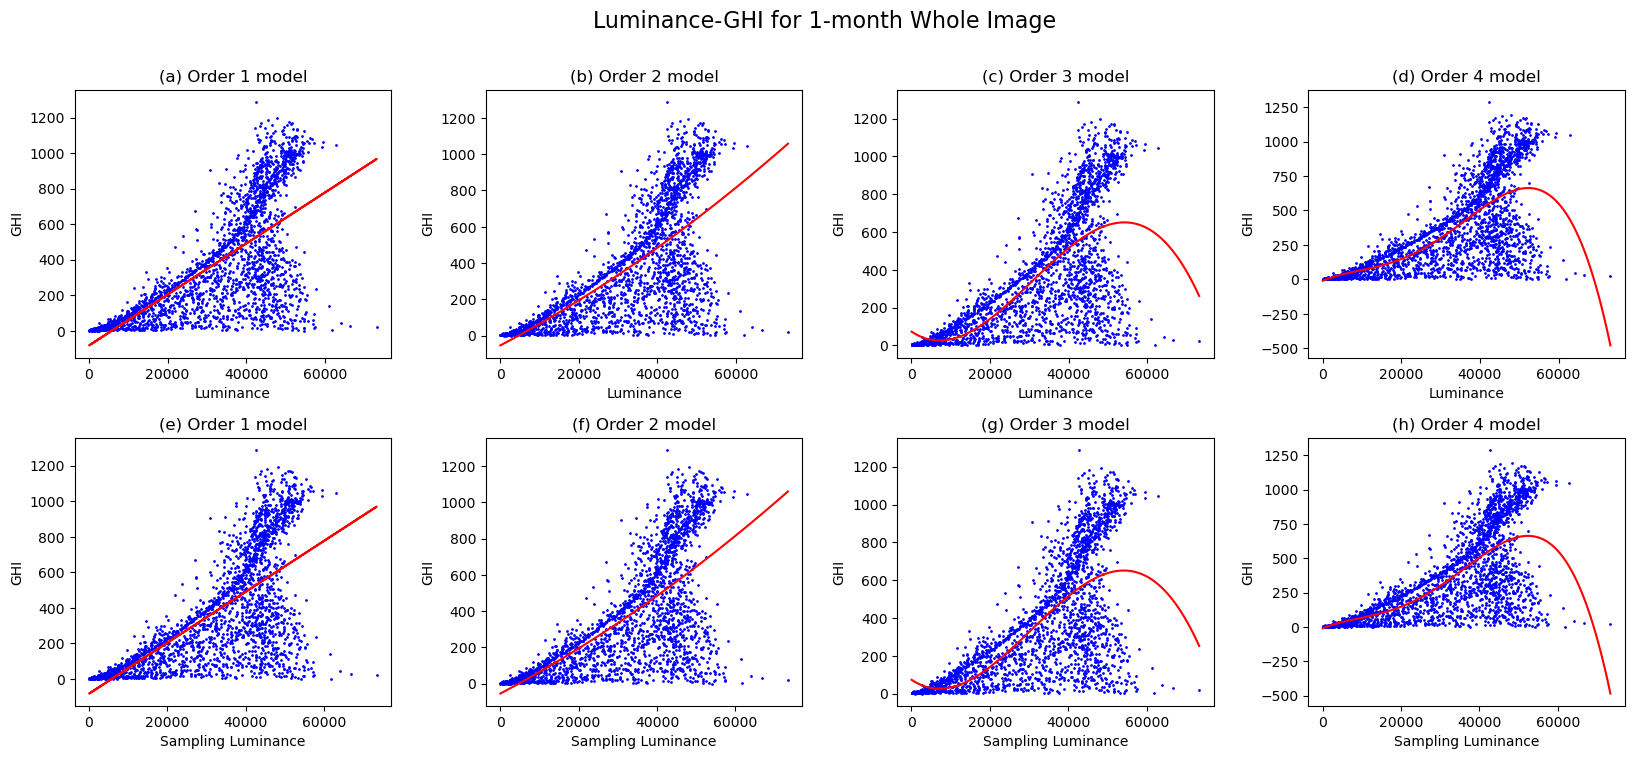

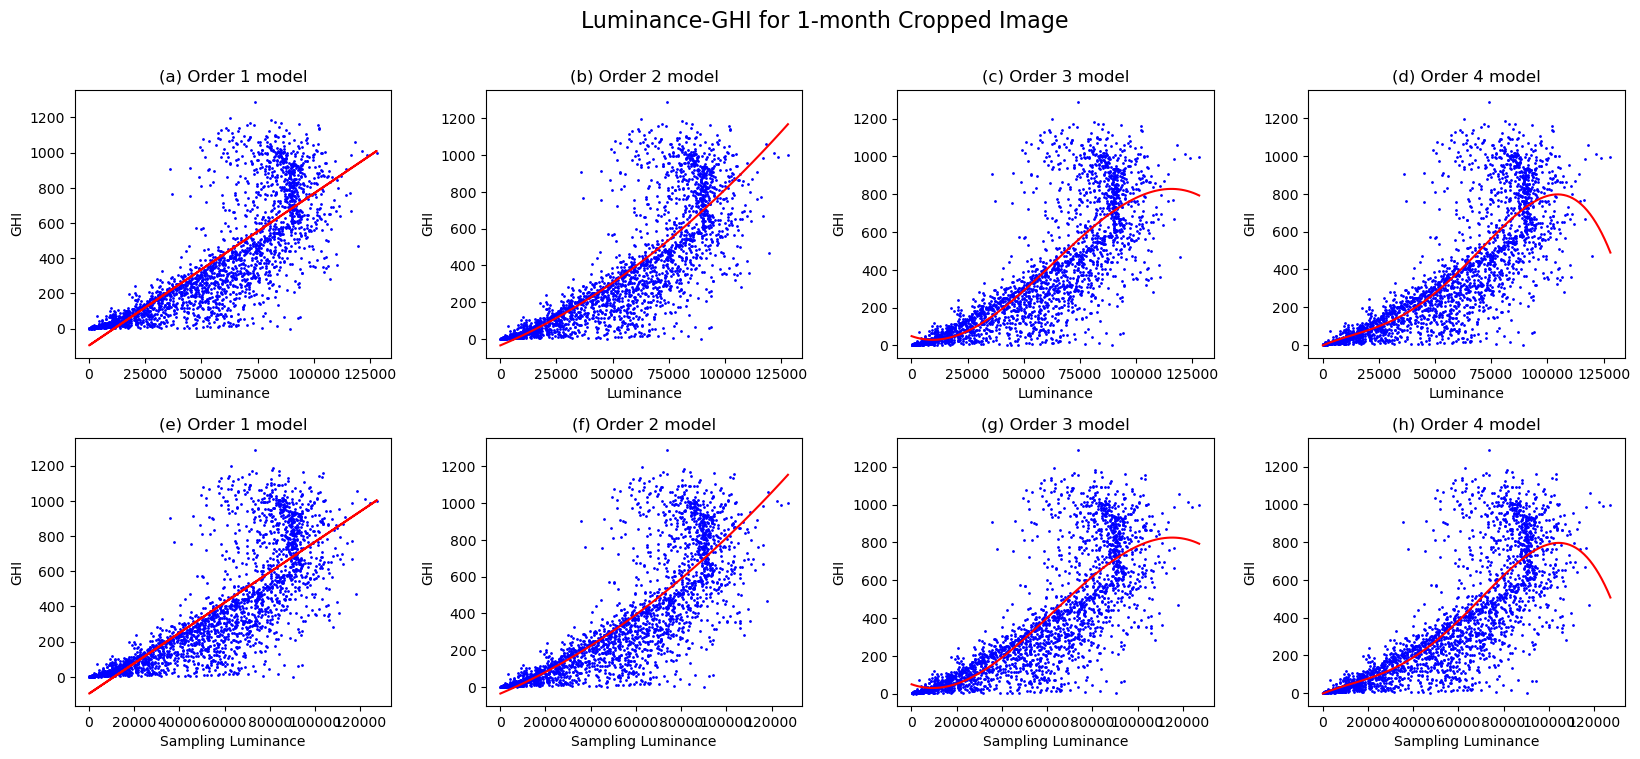

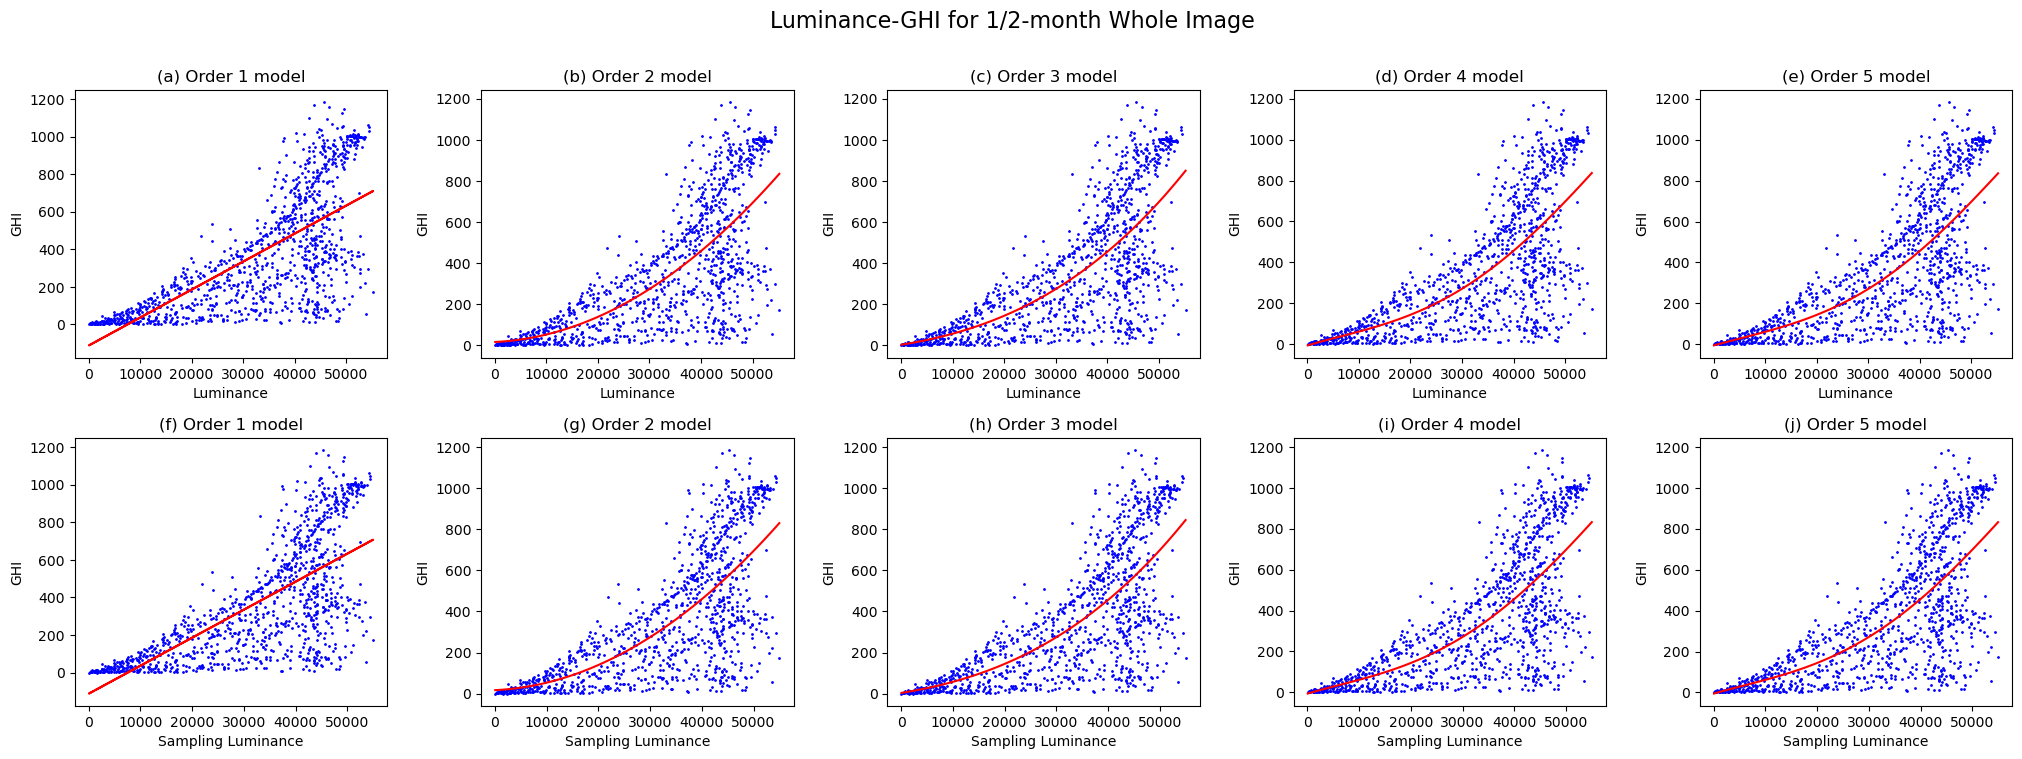

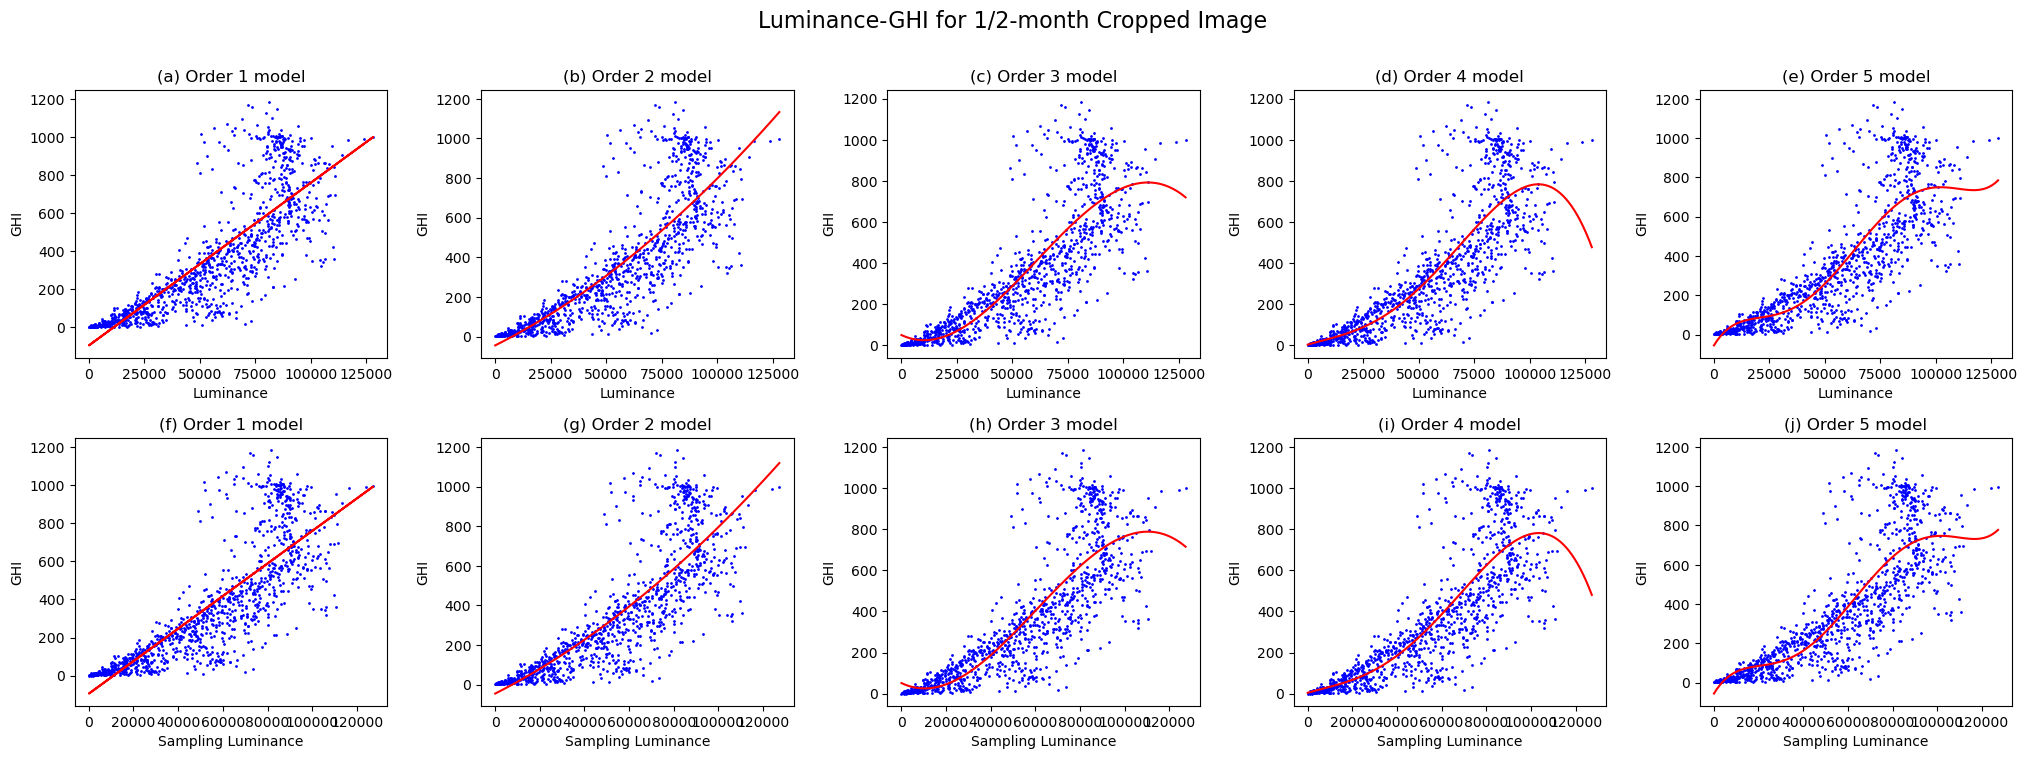

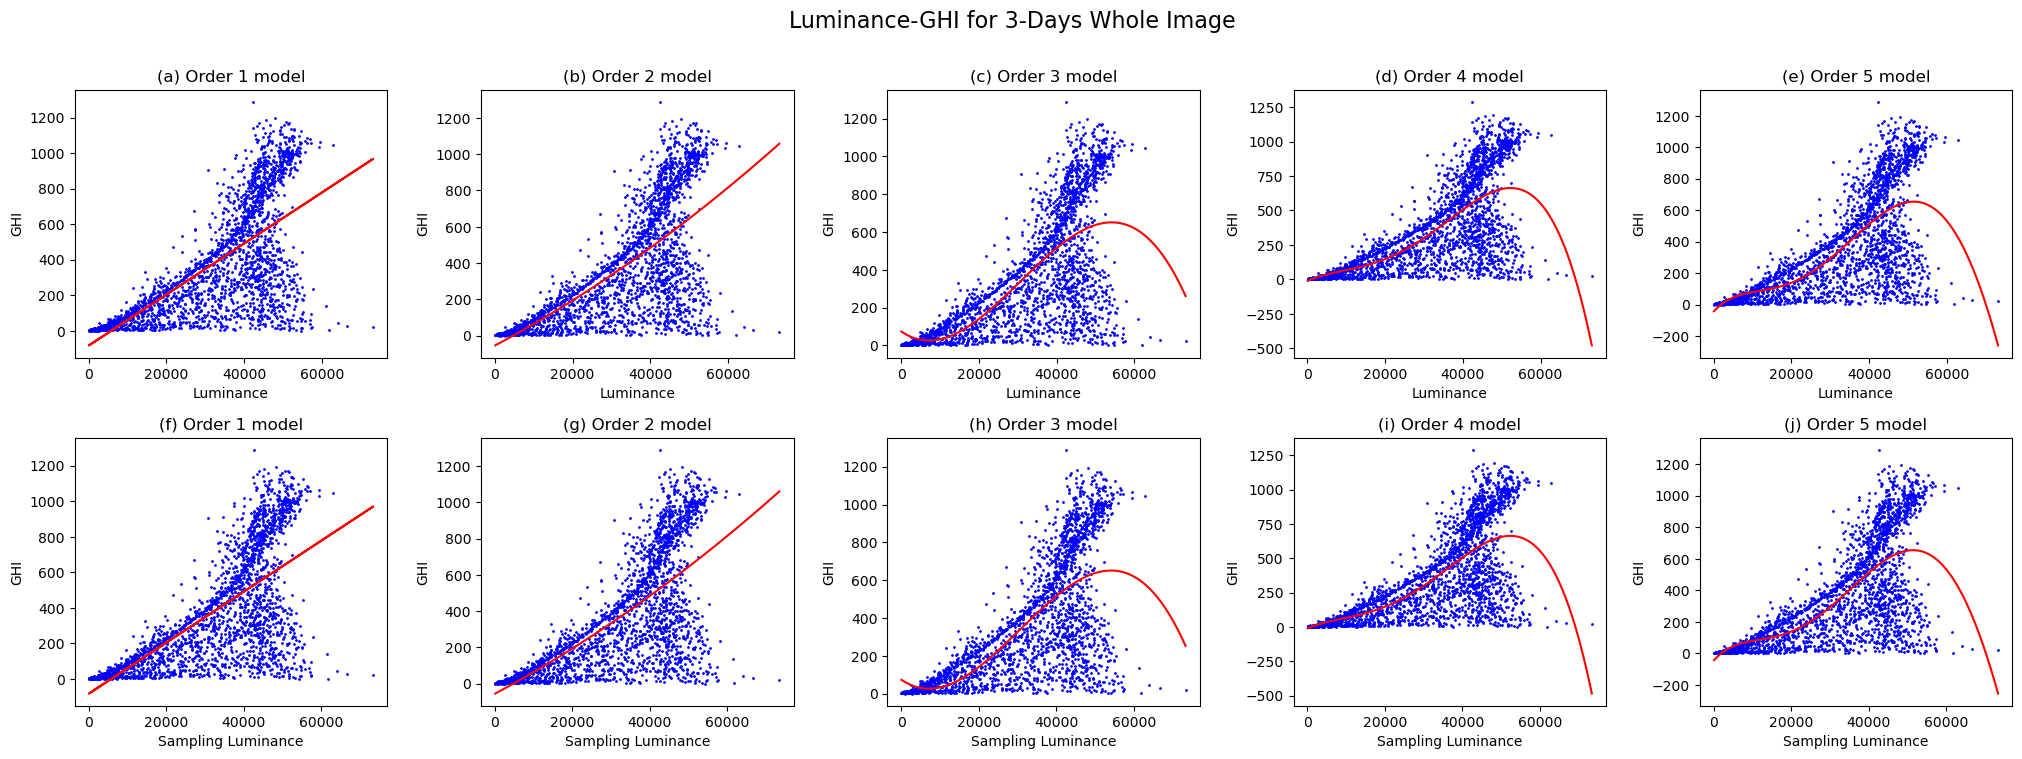

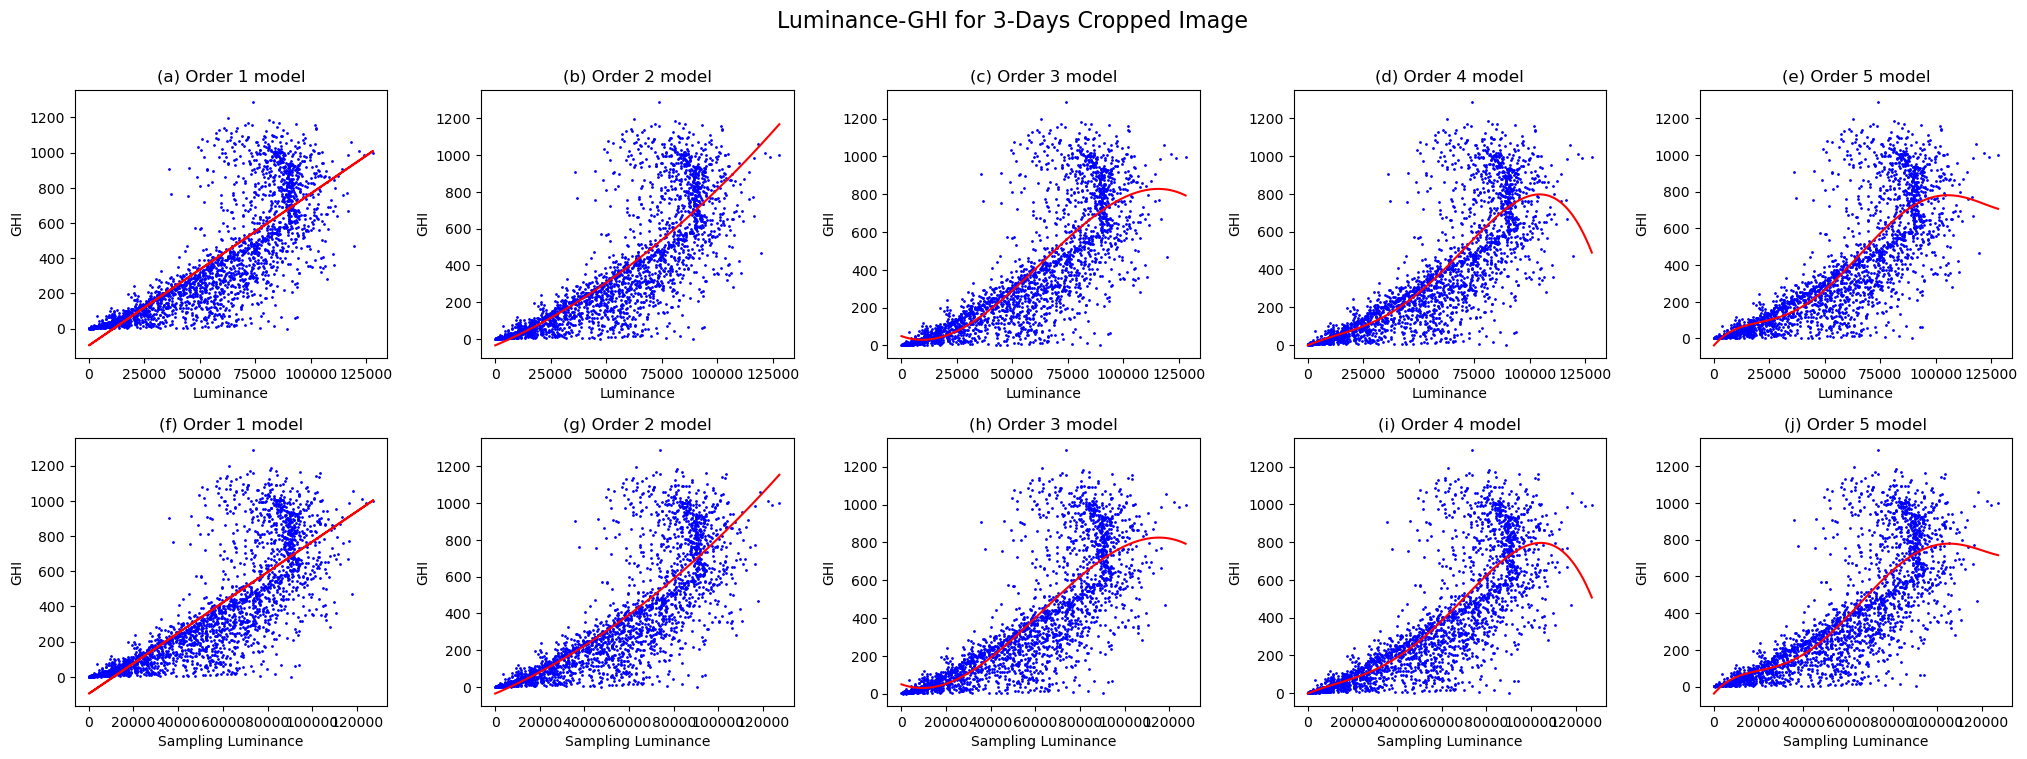

In [13]:
june_result = read_result(directory_path,'202306')

#using 1 month data
w_month,w_sam_month, c_month, c_sam_month = generate_models(june_result,4)
plot_models(w_month,w_sam_month,june_result['Whole Luminance'],june_result['Sampled Whole Luminance'], june_result['Measured GHI'],'1-month Whole Image')
plot_models(c_month,c_sam_month,june_result['Cropped Luminance'],june_result['Sampled Cropped Luminance'], june_result['Measured GHI'],'1-month Cropped Image')

#using half month data
hjune_result = june_result[june_result['Datetime'].dt.day<=len(june_result['Datetime'].dt.day.unique())//2]
w_hmonth,w_sam_hmonth, c_hmonth, c_sam_hmonth = generate_models(hjune_result,5)
plot_models(w_hmonth,w_sam_hmonth,hjune_result['Whole Luminance'],hjune_result['Sampled Whole Luminance'], hjune_result['Measured GHI'],'1/2-month Whole Image')
plot_models(c_hmonth,c_sam_hmonth,hjune_result['Cropped Luminance'],hjune_result['Sampled Cropped Luminance'], hjune_result['Measured GHI'],'1/2-month Cropped Image')

#using three day data
three_day = june_result[june_result['Datetime'].dt.date > datetime(2023,4,28).date()]
w_3d,w_sam_3d,c_3d,c_sam_3d = generate_models(three_day,5)
plot_models(w_3d,w_sam_3d,three_day['Whole Luminance'],three_day['Sampled Whole Luminance'], three_day['Measured GHI'],'3-Days Whole Image')
plot_models(c_3d,c_sam_3d,three_day['Cropped Luminance'],three_day['Sampled Cropped Luminance'], three_day['Measured GHI'],'3-Days Cropped Image')

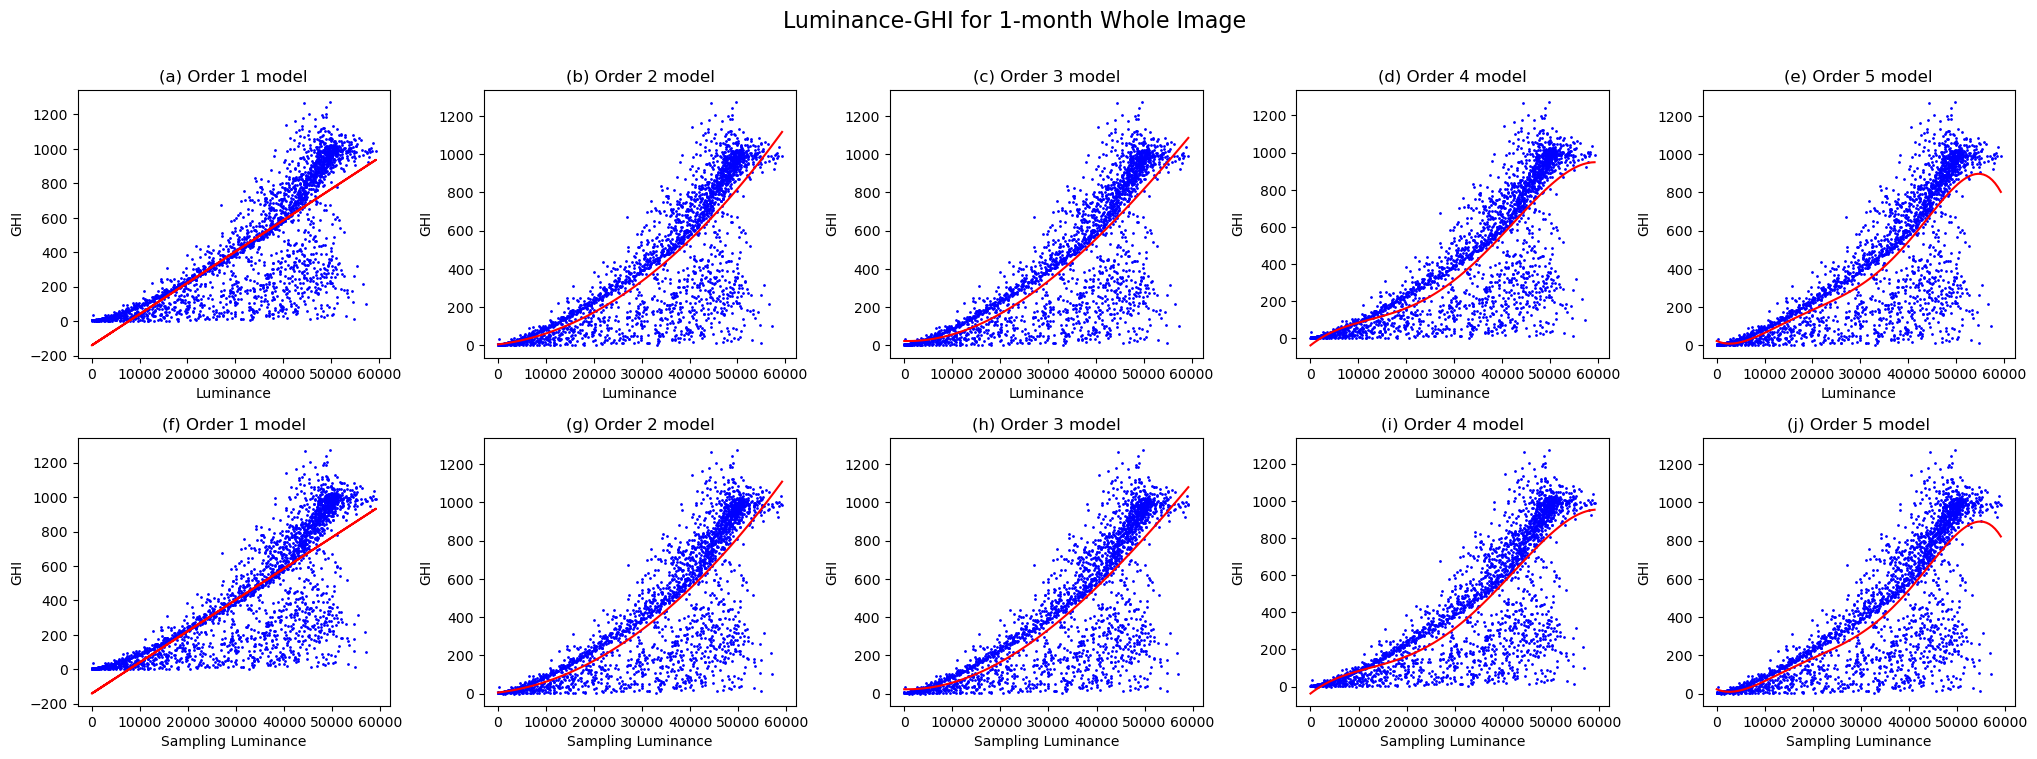

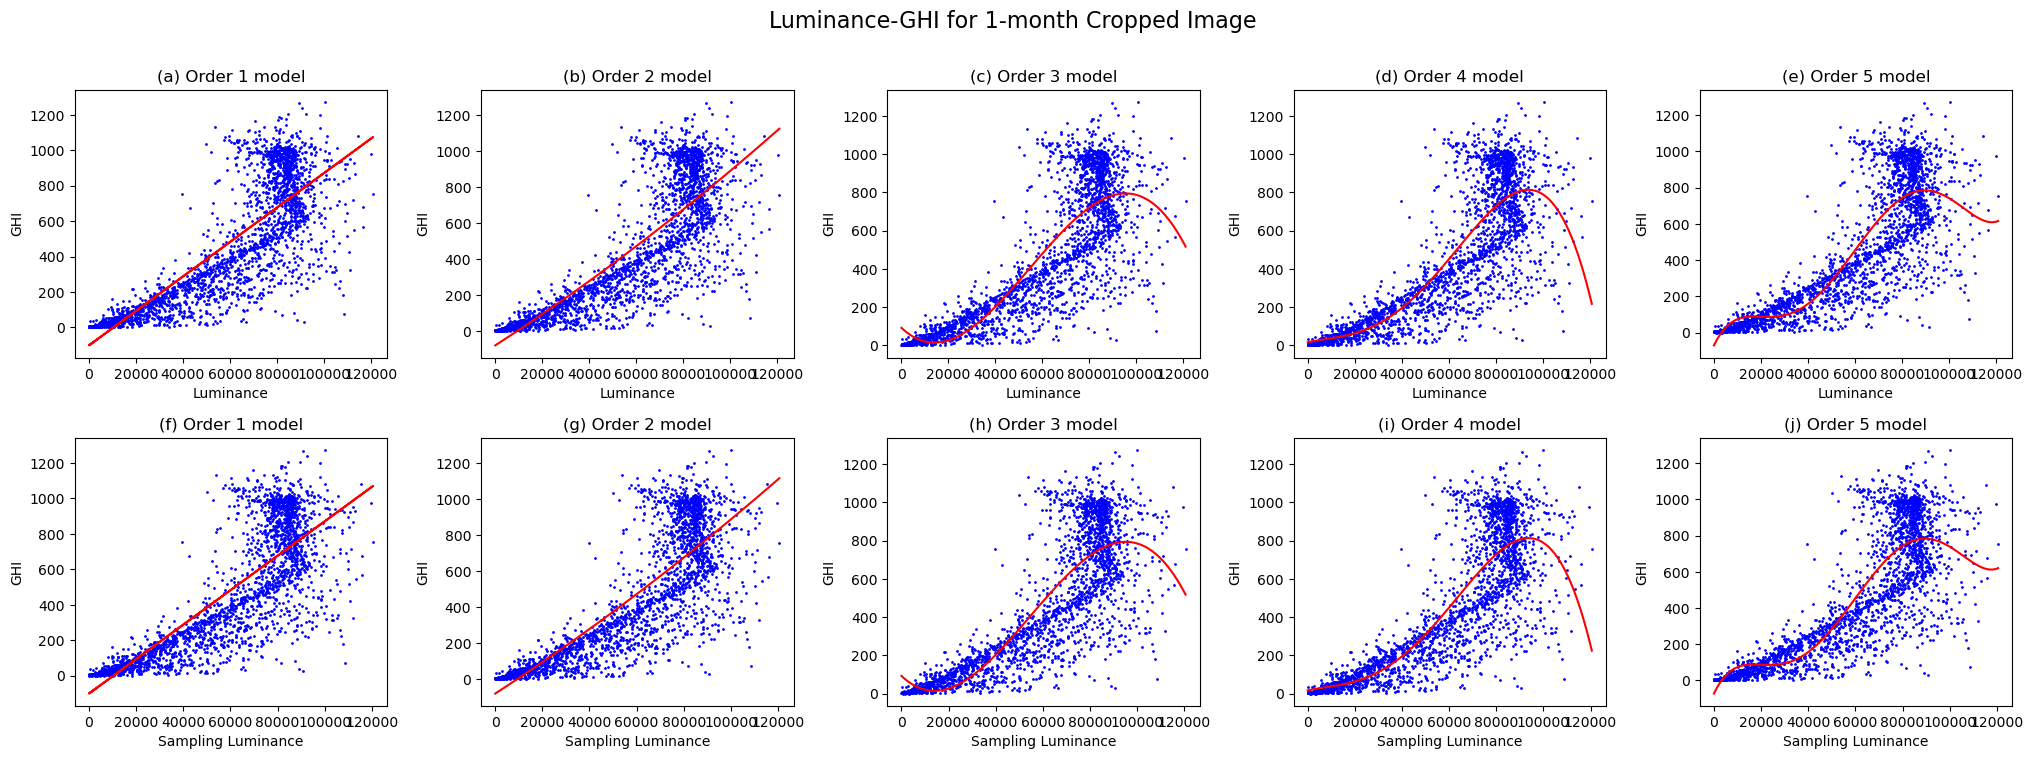

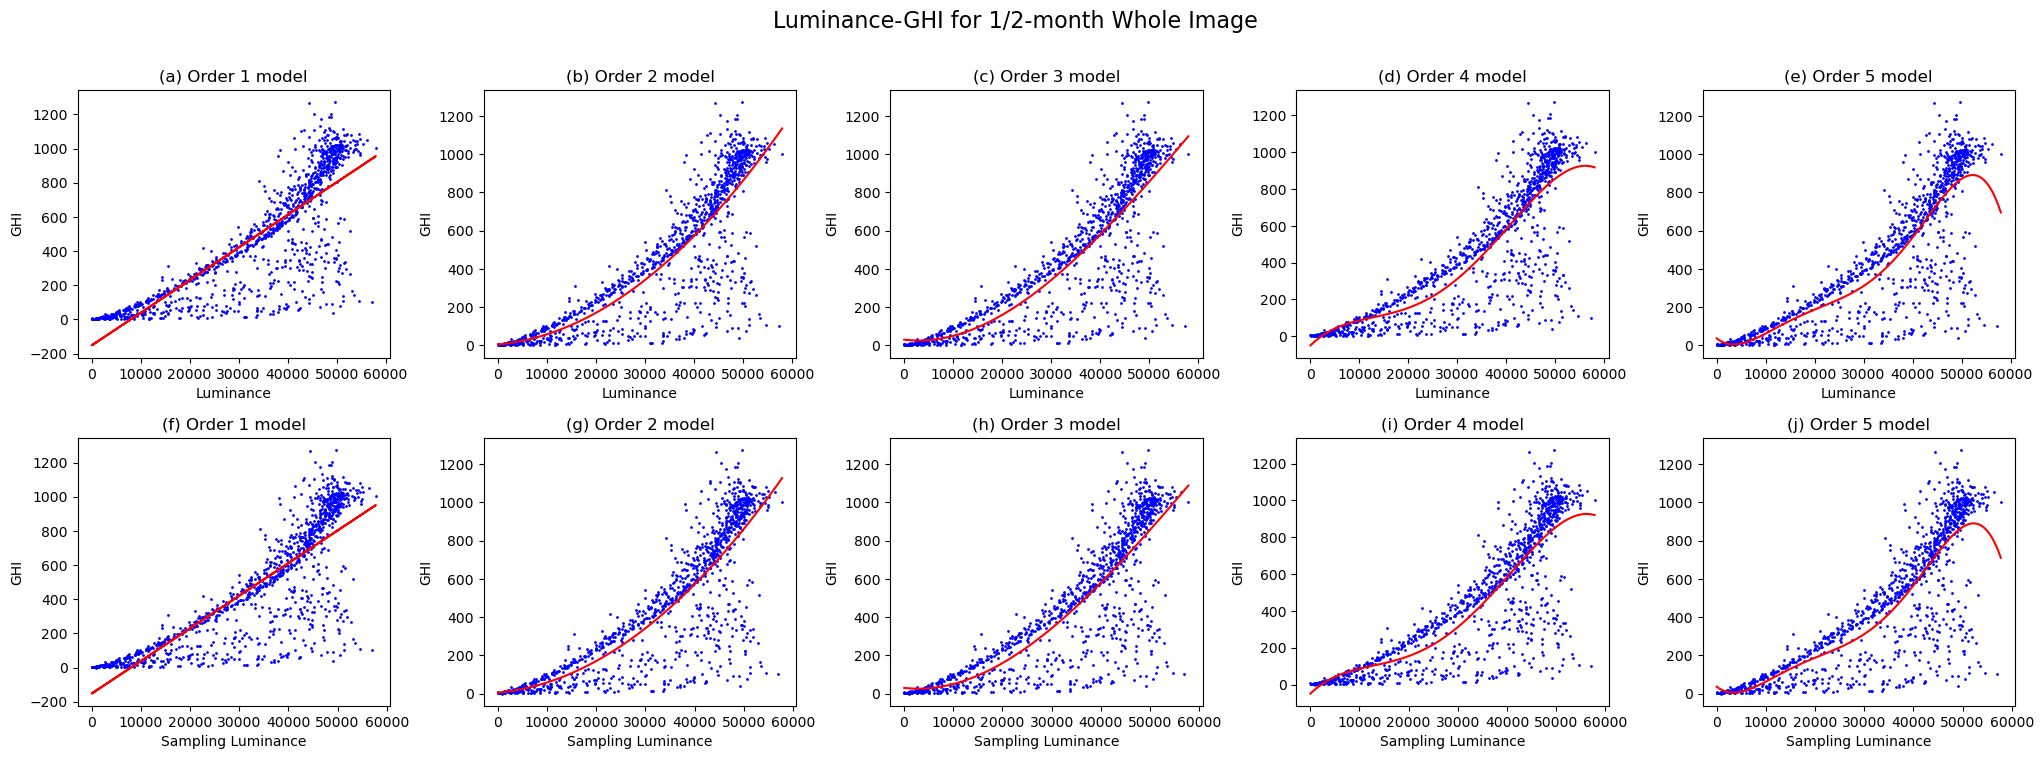

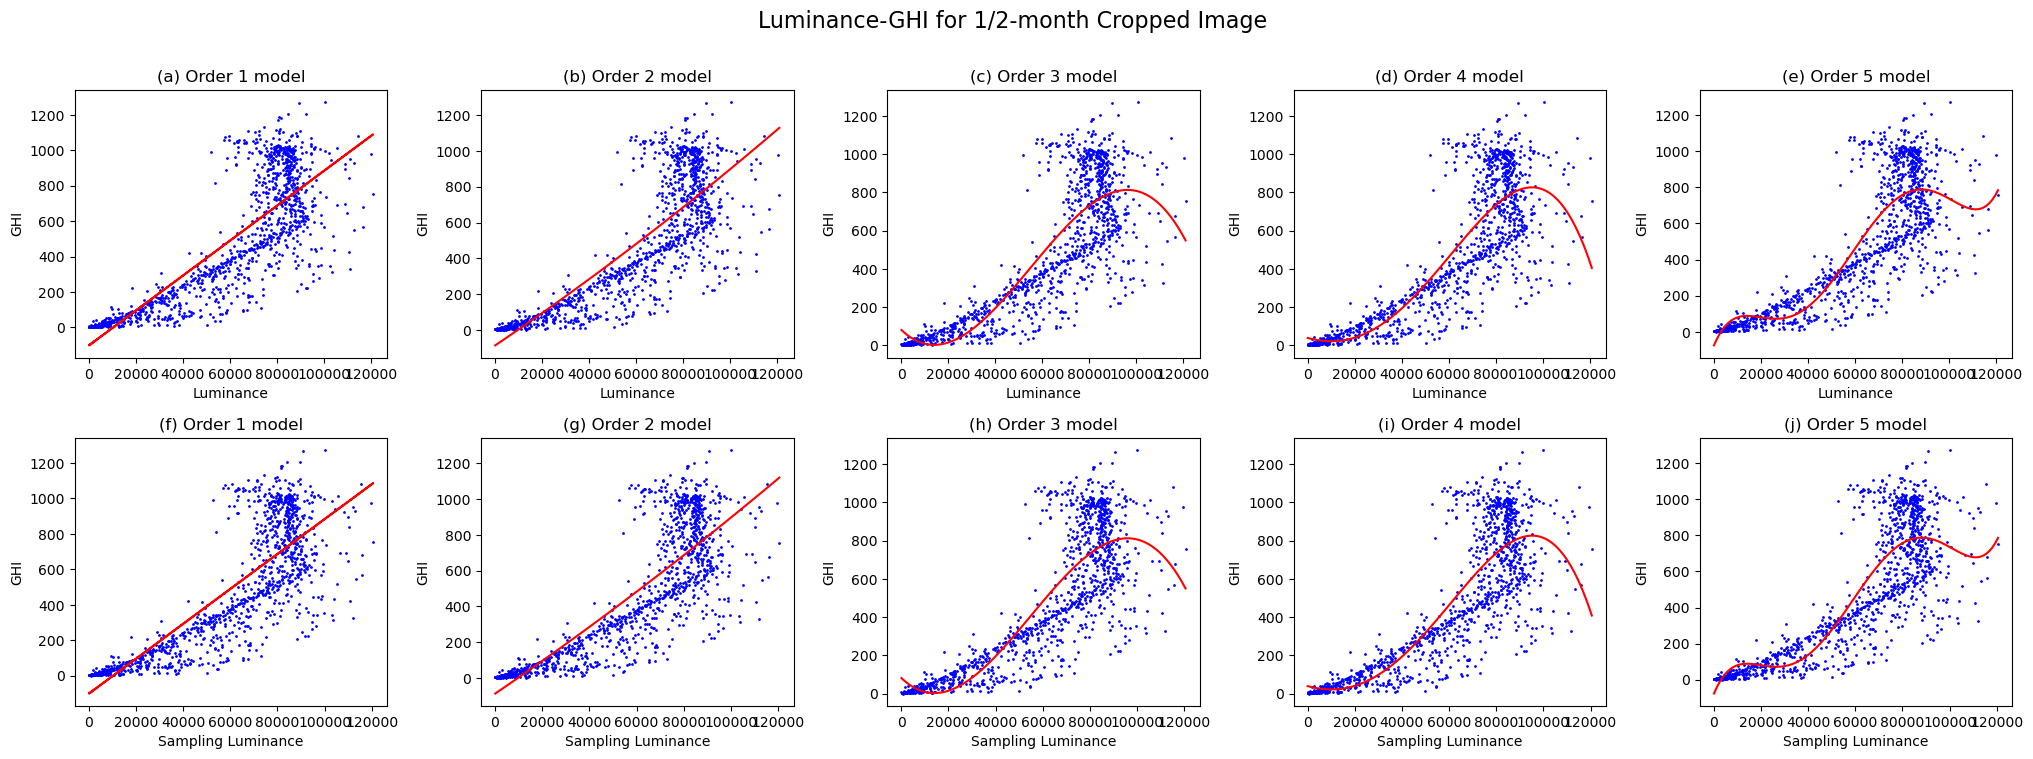

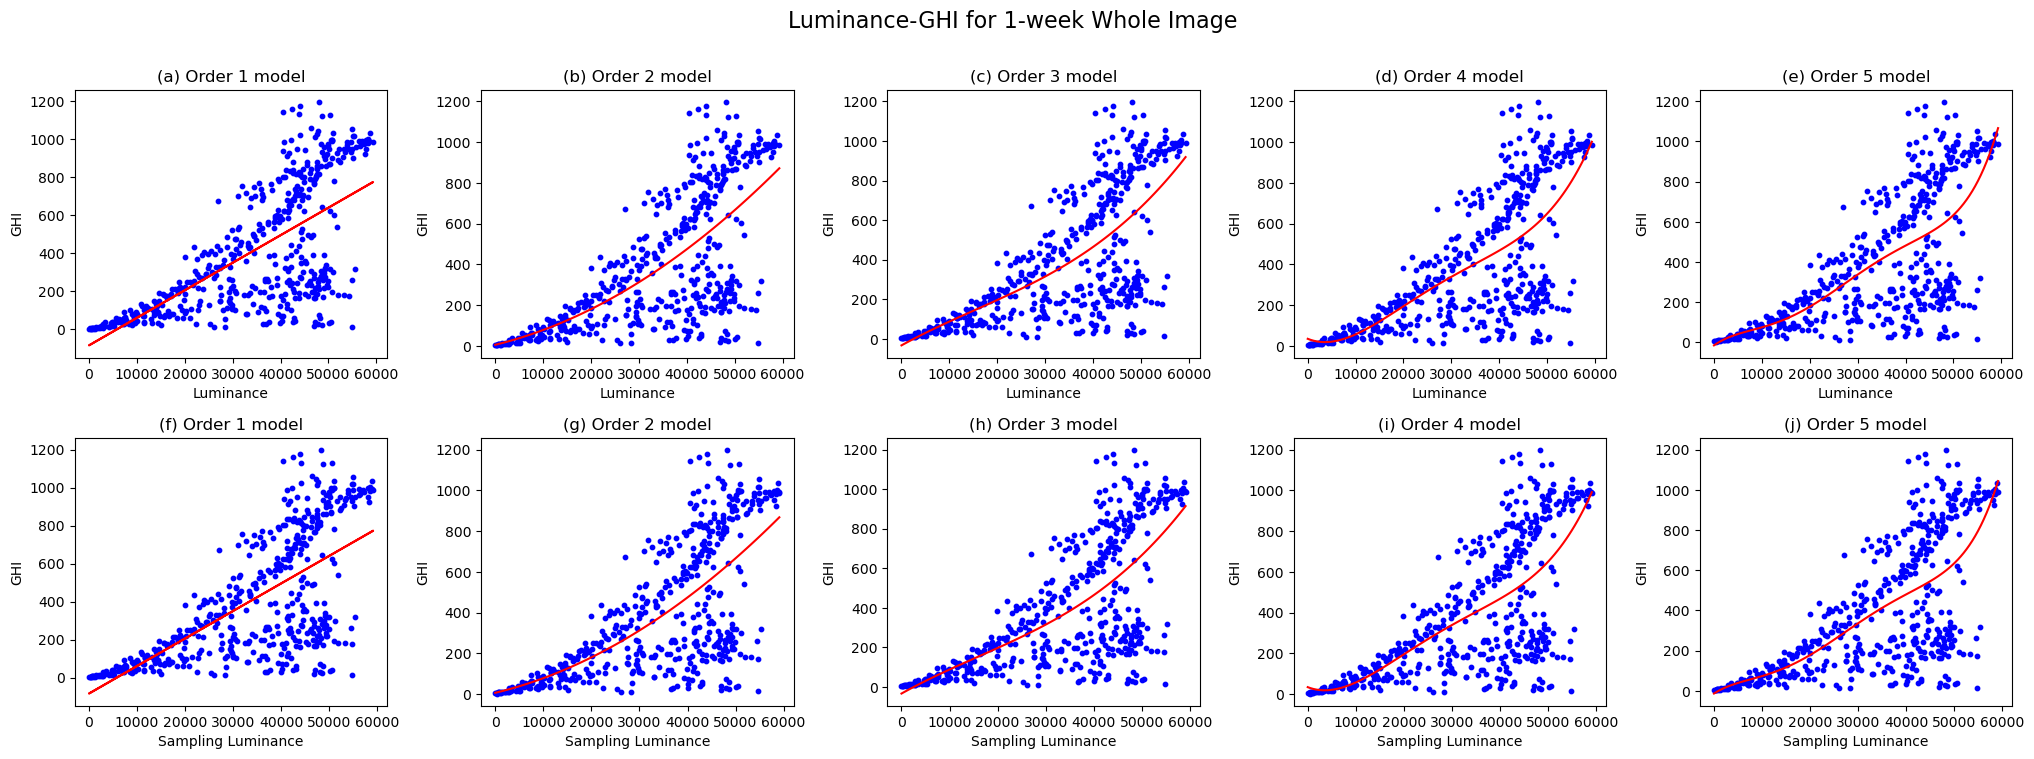

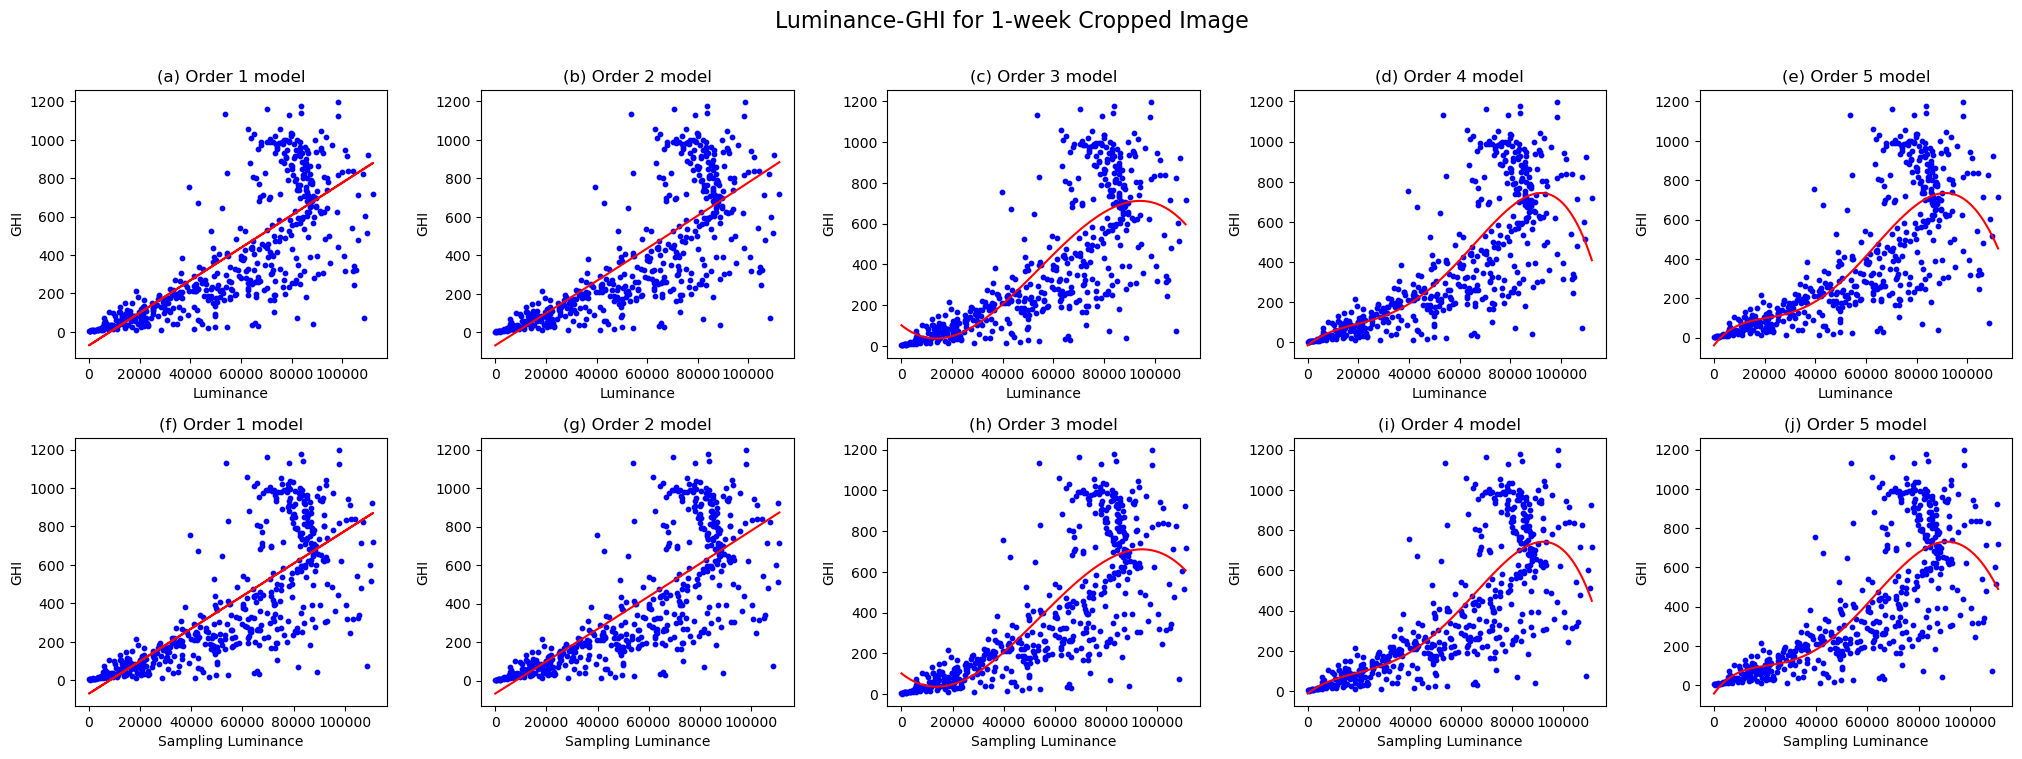

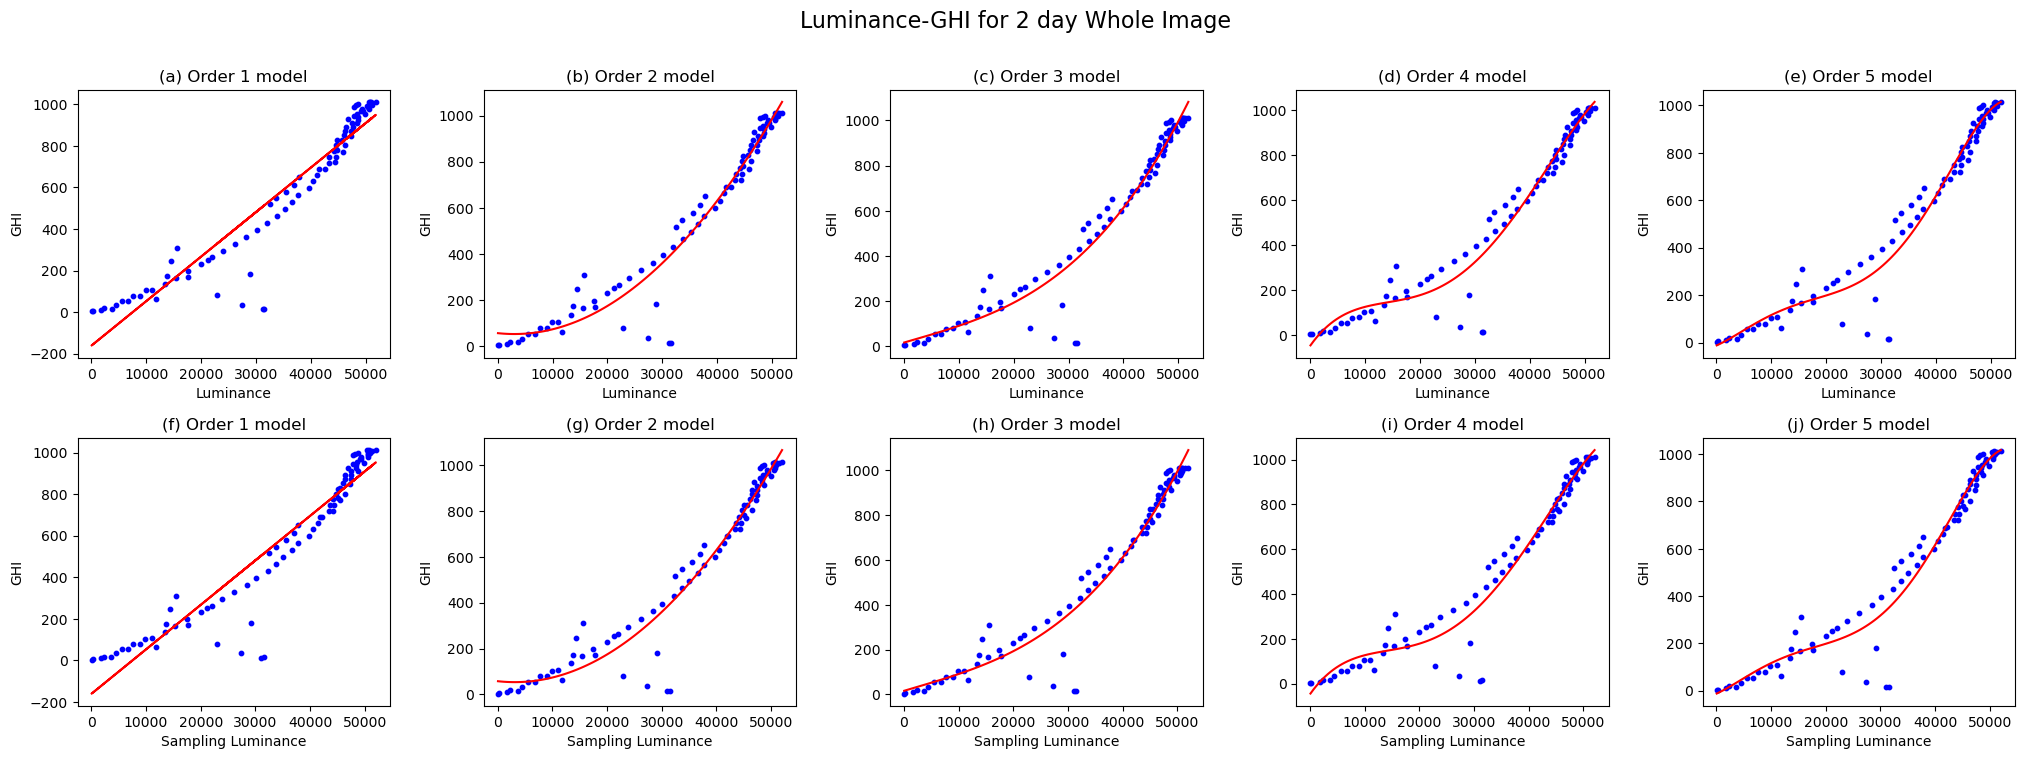

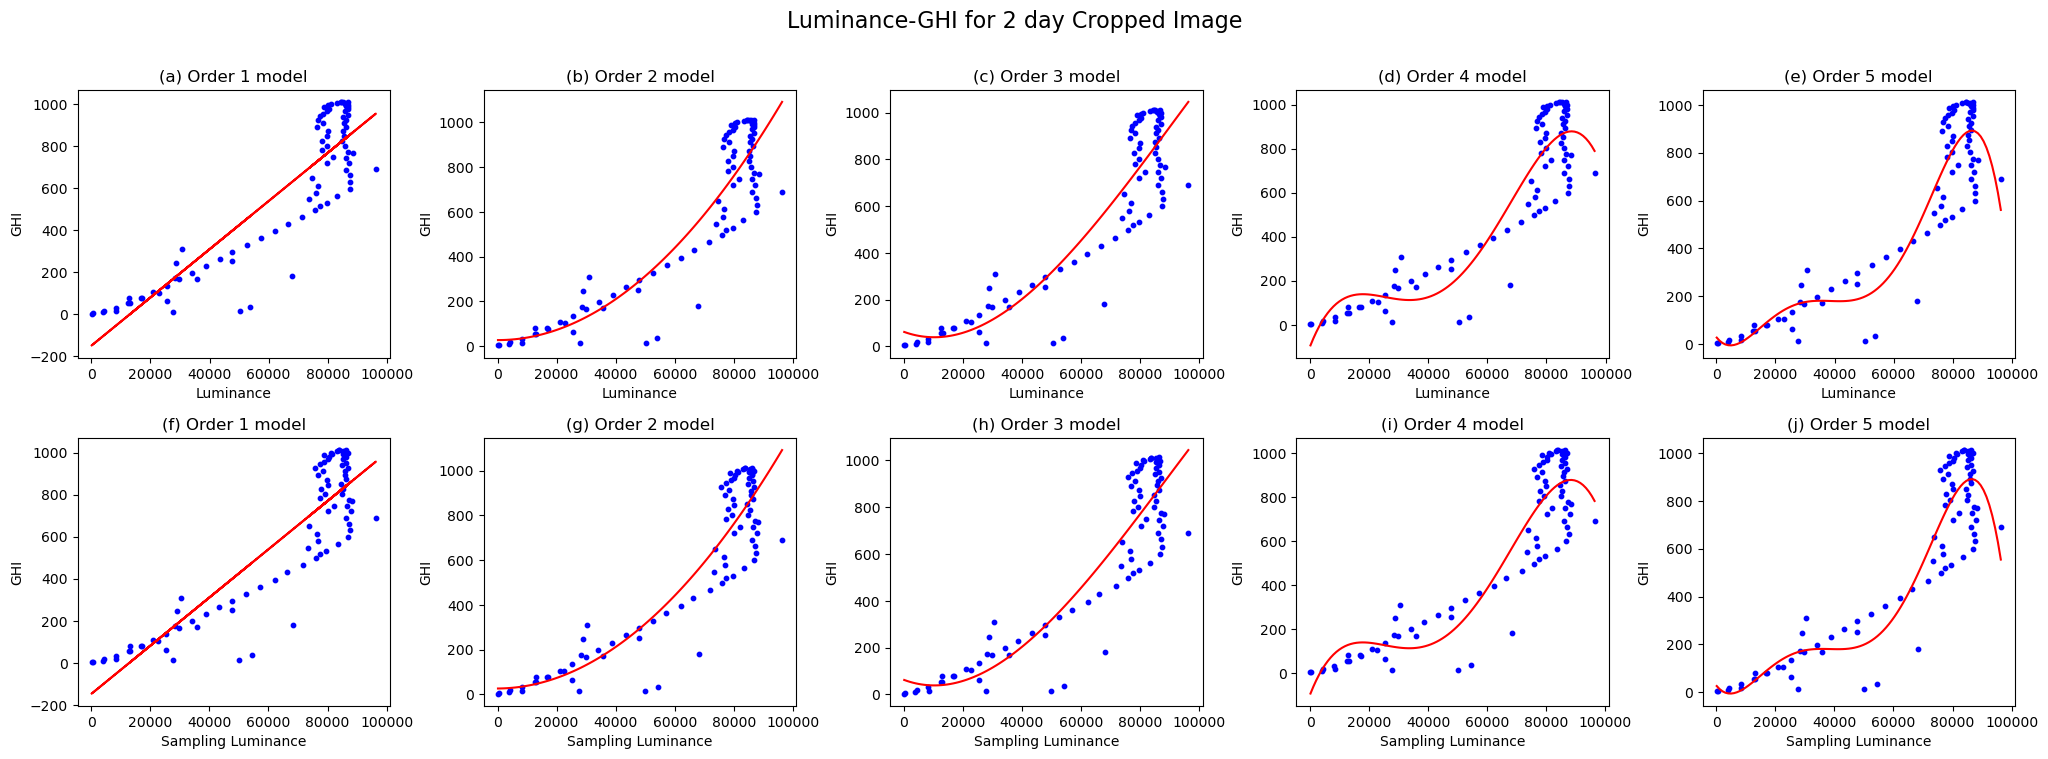

In [14]:
july_result = read_result(directory_path,'202307')
w_month,w_sam_month, c_month, c_sam_month = generate_models(july_result,5)
plot_models(w_month,w_sam_month,july_result['Whole Luminance'],july_result['Sampled Whole Luminance'], july_result['Measured GHI'],'1-month Whole Image')
plot_models(c_month,c_sam_month,july_result['Cropped Luminance'],july_result['Sampled Cropped Luminance'], july_result['Measured GHI'],'1-month Cropped Image')

hjuly_result = july_result[july_result['Datetime'].dt.day<=len(july_result['Datetime'].dt.day.unique())//2]
w_hmonth,w_sam_hmonth, c_hmonth, c_sam_hmonth = generate_models(hjuly_result,5)
plot_models(w_hmonth,w_sam_hmonth,hjuly_result['Whole Luminance'],hjuly_result['Sampled Whole Luminance'], hjuly_result['Measured GHI'],'1/2-month Whole Image')
plot_models(c_hmonth,c_sam_hmonth,hjuly_result['Cropped Luminance'],hjuly_result['Sampled Cropped Luminance'], hjuly_result['Measured GHI'],'1/2-month Cropped Image')

three_day = july_result[(july_result['Datetime'] >= pd.to_datetime('2023-7-25')) & (july_result['Datetime'] <= pd.to_datetime('2023-7-31'))]
w_3d,w_sam_3d,c_3d,c_sam_3d = generate_models(three_day,5)
plot_models(w_3d,w_sam_3d,three_day['Whole Luminance'],three_day['Sampled Whole Luminance'], three_day['Measured GHI'],'1-week Whole Image',10)
plot_models(c_3d,c_sam_3d,three_day['Cropped Luminance'],three_day['Sampled Cropped Luminance'], three_day['Measured GHI'],'1-week Cropped Image',10)

two_day = july_result[(july_result['Datetime'] >= pd.to_datetime('2023-7-01')) & (july_result['Datetime'] <= pd.to_datetime('2023-7-02'))]
w_2d,w_sam_2d,c_2d,c_sam_2d = generate_models(two_day,5)
plot_models(w_2d,w_sam_2d,two_day['Whole Luminance'],two_day['Sampled Whole Luminance'], two_day['Measured GHI'],'2 day Whole Image',10)
plot_models(c_2d,c_sam_2d,two_day['Cropped Luminance'],two_day['Sampled Cropped Luminance'], two_day['Measured GHI'],'2 day Cropped Image',10)

### RMSE & ADJR2

#### R squared

In [59]:
def adjR2(x, y, degree):
    '''
    Return adjusted R-squared value.
    Parameters:
    x: independent variable
    y: dependent variable
    degree: order of the estimation model
    '''
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    result = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))
    return result

r2_1m =pd.DataFrame() #1 month
r2_hm =pd.DataFrame() #half-month
r2_3d =pd.DataFrame() #3 days
r2_2d = pd.DataFrame() #2 days

#Obtain R2 value for 5 order of different estimation model of different data size
for i in range(5):
    r2_1m.loc[i,"Order"] = int(i+1)
    r2_hm.loc[i,"Order"] = int(i+1)
    r2_3d.loc[i,"Order"] = int(i+1)

    print("1 month")
    r2_1m.loc[i,"Whole Luminance"] = adjR2(july_result['Whole Luminance'],july_result['Measured GHI'],i+1)
    r2_1m.loc[i,'Sampled Whole Luminance'] = adjR2(july_result['Sampled Whole Luminance'], july_result['Measured GHI'],i+1)
    r2_1m.loc[i,'Cropped Luminance'] = adjR2(july_result['Cropped Luminance'],july_result['Measured GHI'],i+1)
    r2_1m.loc[i,'Sampled Cropped Luminance'] = adjR2(july_result['Sampled Cropped Luminance'],july_result['Measured GHI'],i+1)

    print("Half month")
    r2_hm.loc[i,"Whole Luminance"] = adjR2(hjuly_result['Whole Luminance'],hjuly_result['Measured GHI'],i+1)
    r2_hm.loc[i,'Sampled Whole Luminance'] = adjR2(hjuly_result['Sampled Whole Luminance'], hjuly_result['Measured GHI'],i+1)
    r2_hm.loc[i,'Cropped Luminance'] = adjR2(hjuly_result['Cropped Luminance'],hjuly_result['Measured GHI'],i+1)
    r2_hm.loc[i,'Sampled Cropped Luminance'] = adjR2(hjuly_result['Sampled Cropped Luminance'],hjuly_result['Measured GHI'],i+1)

    print("3 days")
    r2_3d.loc[i,"Whole Luminance"] = adjR2(three_day['Whole Luminance'],three_day['Measured GHI'],i+1)
    r2_3d.loc[i,'Sampled Whole Luminance'] = adjR2(three_day['Sampled Whole Luminance'], three_day['Measured GHI'],i+1)
    r2_3d.loc[i,'Cropped Luminance'] = adjR2(three_day['Cropped Luminance'],three_day['Measured GHI'],i+1)
    r2_3d.loc[i,'Sampled Cropped Luminance'] = adjR2(three_day['Sampled Cropped Luminance'],three_day['Measured GHI'],i+1)

    print("2 days")
    r2_2d.loc[i,"Whole Luminance"] = adjR2(two_day['Whole Luminance'],two_day['Measured GHI'],i+1)
    r2_2d.loc[i,'Sampled Whole Luminance'] = adjR2(two_day['Sampled Whole Luminance'], two_day['Measured GHI'],i+1)
    r2_2d.loc[i,'Cropped Luminance'] = adjR2(two_day['Cropped Luminance'],two_day['Measured GHI'],i+1)
    r2_2d.loc[i,'Sampled Cropped Luminance'] = adjR2(two_day['Sampled Cropped Luminance'],two_day['Measured GHI'],i+1)

display(r2_1m,r2_hm,r2_3d,r2_2d)
r2_1m.to_csv(directory_path+f'\\1m_r2.csv',index=False)
r2_hm.to_csv(directory_path+f'\\hm_r2.csv',index=False)
r2_3d.to_csv(directory_path+f'\\1w_r2.csv',index=False)


Order  Whole Luminance  Sampled Whole Luminance  Cropped Luminance  \
0    1.0         0.616987                 0.617179           0.658801   
1    2.0         0.640549                 0.640796           0.659361   
2    3.0         0.640657                 0.640887           0.695233   
3    4.0         0.642999                 0.643157           0.700401   
4    5.0         0.644912                 0.644984           0.706268   

   Sampled Cropped Luminance  
0                   0.658340  
1                   0.658814  
2                   0.695243  
3                   0.700441  
4                   0.706465

Order  Whole Luminance  Sampled Whole Luminance  Cropped Luminance  \
0    1.0         0.672045                 0.671731           0.657891   
1    2.0         0.699232                 0.698908           0.658018   
2    3.0         0.699466                 0.699121           0.697571   
3    4.0         0.703233                 0.702808           0.699244   
4    5.0         0.706892                 0.706354           0.710438   

   Sampled Cropped Luminance  
0                   0.657320  
1                   0.657347  
2                   0.697681  
3                   0.699390  
4                   0.710753

Order  Whole Luminance  Sampled Whole Luminance  Cropped Luminance  \
0    1.0         0.458656                 0.459131           0.571536   
1    2.0         0.467860                 0.468535           0.570702   
2    3.0         0.468233                 0.469022           0.602513   
3    4.0         0.470836                 0.471627           0.613060   
4    5.0         0.471587                 0.472155           0.612747   

   Sampled Cropped Luminance  
0                   0.570989  
1                   0.570147  
2                   0.602193  
3                   0.612374  
4                   0.612297

Whole Luminance  Sampled Whole Luminance  Cropped Luminance  \
0         0.893383                 0.893463           0.800988   
1         0.947914                 0.948198           0.829440   
2         0.948962                 0.949344           0.828613   
3         0.952665                 0.953016           0.851995   
4         0.953298                 0.953611           0.867807   

   Sampled Cropped Luminance  
0                   0.799606  
1                   0.827236  
2                   0.826497  
3                   0.850316  
4                   0.865921

#### RMSE

In [39]:
def RMSE(y_actual,y_predict):
    '''
    Return the RMSE value of the estimation model.

    Parameters:
    y_actual: Measured result 
    y_predict: Estimated result
    '''
    rmse = np.sqrt(np.mean((y_actual-y_predict)**2)) 
    return rmse

def clear_sky1(row):
    '''
    Return the clear sky GHI (theoretical GHI). (Dev et al., 2019)
    (Apply to dataframe)
    '''
    zenith = row['Measured Zenith']

    day_of_year = row['Datetime'].date().timetuple().tm_yday

    #Eqn 1 
    tau = 2*np.pi*(day_of_year - 1)/365
    E0 = 1.00011 + 0.034221*np.cos(tau) + 0.001280*np.sin(tau) + 0.000719*np.cos(2*tau) + 0.000077*np.sin(2*tau)
    Isc = 1366.1

    try:
        f1 = math.pow(np.cos(zenith*(np.pi/180)), 1.3644)
        f2 = math.pow(np.e, (-0.0013 * (90 - zenith)))
        Gc = 0.8277*E0*Isc*f1*f2
    except:
        Gc=0
        
    return pd.Series({'Clear Sky GHI':Gc})

def clear_sky(row):
    '''
    Return the clear sky GHI (theoretical GHI).
    (Apply to dataframe)
    '''
    zenith = row['Measured Zenith']
    Gc = 1159.24*math.pow(np.cos(zenith*(np.pi/180)),1.179)*np.exp(-0.0019*(90-zenith))
    return pd.Series({'Clear Sky GHI':Gc})

def evaluate_model(w_models:list,wSam_models:list,c_models:list,cSam_models:list,estimate):
    '''
    Return dataframes of estimated GHI and RMSE of each models. 
    
    Parameters:
    w_models: list of whole, full pixel models
    wSam_models: list of whole, sampled pixel models
    c_models: list of cropped, full pixel models
    cSam_models: list of cropped, sampled pixel models
    estimate: dataframe of processed data
    '''
    rmse = pd.DataFrame()
    for i,(wmodel,wsam_model,cmodel,csam_model) in enumerate(zip(w_models,wSam_models,c_models,cSam_models)):
        #importing the processed luminance value into the model to estimate GHI
        estimate_whole_ghi = wmodel(estimate['Whole Luminance'])
        estimate_swhole_ghi = wsam_model(estimate['Sampled Whole Luminance'])
        estimate_crop_ghi = cmodel(estimate['Cropped Luminance'])
        estimate_scrop_ghi = csam_model(estimate['Sampled Cropped Luminance'])
        
        #add columns to estimate dataframe
        w_name = 'Estimated GHI(whole) order {}'.format(i+1)
        sw_name = 'Estimated GHI(sampled whole) order {}'.format(i+1)
        c_name = 'Estimated GHI(cropped) order {}'.format(i+1)
        sc_name = 'Estimated GHI(sampled cropped) order {}'.format(i+1)
        estimate[w_name] = pd.Series(estimate_whole_ghi)
        estimate[sw_name] = pd.Series(estimate_swhole_ghi)
        estimate[c_name] = pd.Series(estimate_crop_ghi)
        estimate[sc_name] = pd.Series(estimate_scrop_ghi)

        #add columns to rmse dataframe
        rmse.loc[i,"Order"] = int(i+1)
        rmse.loc[i,"Whole image, all pixels"] = RMSE(estimate["Measured GHI"],estimate[w_name])
        rmse.loc[i,"Whole image, sampled"] = RMSE(estimate["Measured GHI"],estimate[sw_name])
        rmse.loc[i,"Crop image, all pixels"] = RMSE(estimate["Measured GHI"],estimate[c_name])
        rmse.loc[i,"Crop image, sampled"] = RMSE(estimate["Measured GHI"],estimate[sc_name])
    
    return estimate,rmse

In [309]:
#read csv of the day used for estimation
estimate = pd.read_csv(directory_path+'202307\\20230703.csv')
estimate['Datetime'] = pd.to_datetime(estimate['Datetime'])

#calculate the theoretical ghi
clear_ghi = estimate.apply(clear_sky,axis=1)
estimate = pd.concat([estimate,clear_ghi],axis = 1)

#evaluate the model
estimate_1m,rmse_1m = evaluate_model(w_month,w_sam_month, c_month, c_sam_month,estimate)
estimate_2d,rmse_2d = evaluate_model(w_2d,w_sam_2d,c_2d,c_sam_2d,estimate)
display(estimate_1m,rmse_1m)
display(estimate_2d,rmse_2d)

Datetime  Measured GHI  Measured Zenith  Measured Azimuth  \
0  2023-07-03 04:40:00       4.91839         89.95754          59.12525   
1  2023-07-03 04:50:00      15.97530         88.46636          60.71683   
2  2023-07-03 05:00:00      31.93440         86.86735          62.28191   
3  2023-07-03 05:10:00      53.00660         85.20424          63.82277   
4  2023-07-03 05:20:00      78.29920         83.49926          65.34169   
..                 ...           ...              ...               ...   
83 2023-07-03 18:40:00       7.69935         81.79020         293.12240   
84 2023-07-03 18:50:00      13.78610         83.52763         294.62139   
85 2023-07-03 19:00:00      17.63700         85.23364         296.13998   
86 2023-07-03 19:10:00       9.41169         86.89756         297.68052   
87 2023-07-03 19:20:00       1.33429         88.49675         299.24532   

     Sun x  Sun y        Cal x       Cal y  Whole Luminance  \
0    177.0  448.0   117.415496  379.022510        59.449331   
1    166.0  463.0   107.099387  397.375099      2143.998790   
2    152.0  476.0    97.985619  415.964688      4313.323685   
3    148.0  491.0    90.126750  434.779565      6642.386603   
4    140.0  505.0    83.549737  453.791234      8721.934900   
..     ...    ...          ...         ...              ...   
83     NaN    NaN  1457.964284  473.386421     10417.218883   
84  1321.0  476.0  1452.691135  454.214678      7181.720400   
85     NaN    NaN  1446.118848  435.206062      4099.789964   
86     NaN    NaN  1438.264321  416.394009      2280.820373   
87     NaN    NaN  1429.154602  397.806571      1250.639124   

    Sampled Whole Luminance  ...  Estimated GHI(cropped) order 3  \
0                 59.117048  ...                       61.442302   
1               2146.097517  ...                       47.573599   
2               4291.733900  ...                       39.901450   
3               6628.646242  ...                       39.369535   
4               8732.917525  ...                       46.010109   
..                      ...  ...                             ...   
83             10398.571520  ...                       41.062351   
84              7191.462594  ...                       39.718483   
85              4127.284935  ...                       44.284063   
86              2308.562511  ...                       55.121741   
87              1243.745127  ...                       57.384909   

    Estimated GHI(sampled cropped) order 3  Estimated GHI(whole) order 4  \
0                                61.988000                    -44.603701   
1                                47.780386                     17.057854   
2                                39.959137                     63.336109   
3                                39.306201                     97.308002   
4                                45.786914                    117.569137   
..                                     ...                           ...   
83                               41.083268                    129.228213   
84                               39.871100                    103.337778   
85                               44.801012                     59.475164   
86                               55.615126                     20.472875   
87                               57.828122                     -7.076029   

    Estimated GHI(sampled whole) order 4  Estimated GHI(cropped) order 4  \
0                             -44.429045                      -94.808106   
1                              17.251871                       11.180640   
2                              63.092236                       82.593787   
3                              97.313619                      123.288448   
4                             117.854468                      137.697517   
..                                   ...                             ...   
83                            129.333904                      131.055657   
84                

Order  Whole image, all pixels  Whole image, sampled  \
0    1.0               137.017098            136.807860   
1    2.0               115.421400            115.214889   
2    3.0               115.512795            115.304499   
3    4.0               114.474800            114.343720   
4    5.0               109.968015            109.943561   

   Crop image, all pixels  Crop image, sampled  
0              187.379234           186.734601  
1              187.012159           186.361958  
2              164.586194           163.913692  
3              160.351248           159.535095  
4              155.423354           154.794918

Datetime  Measured GHI  Measured Zenith  Measured Azimuth  \
0  2023-07-03 04:40:00       4.91839         89.95754          59.12525   
1  2023-07-03 04:50:00      15.97530         88.46636          60.71683   
2  2023-07-03 05:00:00      31.93440         86.86735          62.28191   
3  2023-07-03 05:10:00      53.00660         85.20424          63.82277   
4  2023-07-03 05:20:00      78.29920         83.49926          65.34169   
..                 ...           ...              ...               ...   
83 2023-07-03 18:40:00       7.69935         81.79020         293.12240   
84 2023-07-03 18:50:00      13.78610         83.52763         294.62139   
85 2023-07-03 19:00:00      17.63700         85.23364         296.13998   
86 2023-07-03 19:10:00       9.41169         86.89756         297.68052   
87 2023-07-03 19:20:00       1.33429         88.49675         299.24532   

     Sun x  Sun y        Cal x       Cal y  Whole Luminance  \
0    177.0  448.0   117.415496  379.022510        59.449331   
1    166.0  463.0   107.099387  397.375099      2143.998790   
2    152.0  476.0    97.985619  415.964688      4313.323685   
3    148.0  491.0    90.126750  434.779565      6642.386603   
4    140.0  505.0    83.549737  453.791234      8721.934900   
..     ...    ...          ...         ...              ...   
83     NaN    NaN  1457.964284  473.386421     10417.218883   
84  1321.0  476.0  1452.691135  454.214678      7181.720400   
85     NaN    NaN  1446.118848  435.206062      4099.789964   
86     NaN    NaN  1438.264321  416.394009      2280.820373   
87     NaN    NaN  1429.154602  397.806571      1250.639124   

    Sampled Whole Luminance  ...  Estimated GHI(cropped) order 3  \
0                 59.117048  ...                       61.442302   
1               2146.097517  ...                       47.573599   
2               4291.733900  ...                       39.901450   
3               6628.646242  ...                       39.369535   
4               8732.917525  ...                       46.010109   
..                      ...  ...                             ...   
83             10398.571520  ...                       41.062351   
84              7191.462594  ...                       39.718483   
85              4127.284935  ...                       44.284063   
86              2308.562511  ...                       55.121741   
87              1243.745127  ...                       57.384909   

    Estimated GHI(sampled cropped) order 3  Estimated GHI(whole) order 4  \
0                                61.988000                    -44.603701   
1                                47.780386                     17.057854   
2                                39.959137                     63.336109   
3                                39.306201                     97.308002   
4                                45.786914                    117.569137   
..                                     ...                           ...   
83                               41.083268                    129.228213   
84                               39.871100                    103.337778   
85                               44.801012                     59.475164   
86                               55.615126                     20.472875   
87                               57.828122                     -7.076029   

    Estimated GHI(sampled whole) order 4  Estimated GHI(cropped) order 4  \
0                             -44.429045                      -94.808106   
1                              17.251871                       11.180640   
2                              63.092236                       82.593787   
3                              97.313619                      123.288448   
4                             117.854468                      137.697517   
..                                   ...                             ...   
83                            129.333904                      131.055657   
84                

Order  Whole image, all pixels  Whole image, sampled  \
0    1.0                73.555044             73.478398   
1    2.0                45.736359             46.276215   
2    3.0                49.461000             50.219468   
3    4.0                57.533881             58.116209   
4    5.0                59.214844             59.712772   

   Crop image, all pixels  Crop image, sampled  
0              156.024564           155.308205  
1              150.277947           149.554165  
2              147.605781           146.781115  
3              140.897307           140.127331  
4              141.301845           140.601015

In [311]:
estimate_hm,_,rmse_hm = evaluate_model(w_hmonth,w_sam_hmonth, c_hmonth, c_sam_hmonth,estimate)
#rmse_hm.to_csv(directory_path+f'\\hm_rmse.csv',index=False)
display(estimate_hm,rmse_hm)

Datetime  Measured GHI  Measured Zenith  Measured Azimuth  \
0  2023-07-03 04:40:00       4.91839         89.95754          59.12525   
1  2023-07-03 04:50:00      15.97530         88.46636          60.71683   
2  2023-07-03 05:00:00      31.93440         86.86735          62.28191   
3  2023-07-03 05:10:00      53.00660         85.20424          63.82277   
4  2023-07-03 05:20:00      78.29920         83.49926          65.34169   
..                 ...           ...              ...               ...   
83 2023-07-03 18:40:00       7.69935         81.79020         293.12240   
84 2023-07-03 18:50:00      13.78610         83.52763         294.62139   
85 2023-07-03 19:00:00      17.63700         85.23364         296.13998   
86 2023-07-03 19:10:00       9.41169         86.89756         297.68052   
87 2023-07-03 19:20:00       1.33429         88.49675         299.24532   

     Sun x  Sun y        Cal x       Cal y  Whole Luminance  \
0    177.0  448.0   117.415496  379.022510        59.449331   
1    166.0  463.0   107.099387  397.375099      2143.998790   
2    152.0  476.0    97.985619  415.964688      4313.323685   
3    148.0  491.0    90.126750  434.779565      6642.386603   
4    140.0  505.0    83.549737  453.791234      8721.934900   
..     ...    ...          ...         ...              ...   
83     NaN    NaN  1457.964284  473.386421     10417.218883   
84  1321.0  476.0  1452.691135  454.214678      7181.720400   
85     NaN    NaN  1446.118848  435.206062      4099.789964   
86     NaN    NaN  1438.264321  416.394009      2280.820373   
87     NaN    NaN  1429.154602  397.806571      1250.639124   

    Sampled Whole Luminance  ...  Estimated GHI(cropped) order 3  \
0                 59.117048  ...                       80.097742   
1               2146.097517  ...                       42.735600   
2               4291.733900  ...                       16.966511   
3               6628.646242  ...                        4.004357   
4               8732.917525  ...                        4.569136   
..                      ...  ...                             ...   
83             10398.571520  ...                        2.778834   
84              7191.462594  ...                        3.510006   
85              4127.284935  ...                       32.795777   
86              2308.562511  ...                       63.616316   
87              1243.745127  ...                       69.591210   

    Estimated GHI(sampled cropped) order 3  Estimated GHI(whole) order 4  \
0                                80.382408                    -48.897699   
1                                42.718655                     -2.773775   
2                                17.017235                     32.532179   
3                                 3.700000                     59.650144   
4                                 4.170360                     77.299644   
..                                     ...                           ...   
83                                2.476925                     88.788827   
84                                2.997576                     64.715319   
85                               33.918988                     29.540307   
86                               64.029056                     -0.198428   
87                               69.777647                    -20.895844   

    Estimated GHI(sampled whole) order 4  Estimated GHI(cropped) order 4  \
0                             -48.485250                       38.629982   
1                              -2.579663                       28.435055   
2                              32.214157                       22.561098   
3                              59.398400                       22.461331   
4                              77.238178                       28.828505   
..                                   ...                             ...   
83                             88.540690                       24.093771   
84                

Order  Whole image, all pixels  Whole image, sampled  \
0    1.0               115.807711            115.629750   
1    2.0                90.156399             89.985589   
2    3.0                90.949145             90.779798   
3    4.0                93.469611             93.494061   
4    5.0                89.456524             89.659894   

   Crop image, all pixels  Crop image, sampled  
0              182.724061           182.003040  
1              182.428938           181.719133  
2              160.604646           159.796564  
3              158.427387           157.490186  
4              151.350632           150.774445

In [313]:
estimate_3d,_,rmse_3d = evaluate_model(w_3d,w_sam_3d,c_3d,c_sam_3d,estimate)
#rmse_3d.to_csv(directory_path+f'\\1week_rmse.csv',index=False)
display(estimate_3d,rmse_3d)

Datetime  Measured GHI  Measured Zenith  Measured Azimuth  \
0  2023-07-03 04:40:00       4.91839         89.95754          59.12525   
1  2023-07-03 04:50:00      15.97530         88.46636          60.71683   
2  2023-07-03 05:00:00      31.93440         86.86735          62.28191   
3  2023-07-03 05:10:00      53.00660         85.20424          63.82277   
4  2023-07-03 05:20:00      78.29920         83.49926          65.34169   
..                 ...           ...              ...               ...   
83 2023-07-03 18:40:00       7.69935         81.79020         293.12240   
84 2023-07-03 18:50:00      13.78610         83.52763         294.62139   
85 2023-07-03 19:00:00      17.63700         85.23364         296.13998   
86 2023-07-03 19:10:00       9.41169         86.89756         297.68052   
87 2023-07-03 19:20:00       1.33429         88.49675         299.24532   

     Sun x  Sun y        Cal x       Cal y  Whole Luminance  \
0    177.0  448.0   117.415496  379.022510        59.449331   
1    166.0  463.0   107.099387  397.375099      2143.998790   
2    152.0  476.0    97.985619  415.964688      4313.323685   
3    148.0  491.0    90.126750  434.779565      6642.386603   
4    140.0  505.0    83.549737  453.791234      8721.934900   
..     ...    ...          ...         ...              ...   
83     NaN    NaN  1457.964284  473.386421     10417.218883   
84  1321.0  476.0  1452.691135  454.214678      7181.720400   
85     NaN    NaN  1446.118848  435.206062      4099.789964   
86     NaN    NaN  1438.264321  416.394009      2280.820373   
87     NaN    NaN  1429.154602  397.806571      1250.639124   

    Sampled Whole Luminance  ...  Estimated GHI(cropped) order 3  \
0                 59.117048  ...                       99.955024   
1               2146.097517  ...                       68.442710   
2               4291.733900  ...                       47.007488   
3               6628.646242  ...                       36.685713   
4               8732.917525  ...                       37.985097   
..                      ...  ...                             ...   
83             10398.571520  ...                       35.937385   
84              7191.462594  ...                       36.340611   
85              4127.284935  ...                       60.125131   
86              2308.562511  ...                       86.018816   
87              1243.745127  ...                       91.065868   

    Estimated GHI(sampled cropped) order 3  Estimated GHI(whole) order 4  \
0                               100.037064                     33.945103   
1                                68.392750                     20.738709   
2                                47.111634                     18.887377   
3                                36.583576                     27.936248   
4                                37.837116                     43.711262   
..                                     ...                           ...   
83                               35.871319                     60.791957   
84                               36.111847                     31.403309   
85                               61.058663                     18.593316   
86                               86.259943                     20.286648   
87                               91.097712                     24.904087   

    Estimated GHI(sampled whole) order 4  Estimated GHI(cropped) order 4  \
0                              33.112305                      -13.561598   
1                              20.386719                       19.676019   
2                              18.880799                       45.569166   
3                              28.156126                       65.855152   
4                              44.261692                       81.109015   
..                                   ...                             ...   
83                             61.100251                       71.939779   
84                

Order  Whole image, all pixels  Whole image, sampled  \
0    1.0               219.885731            219.532759   
1    2.0               211.727358            211.231889   
2    3.0               214.506508            214.087382   
3    4.0               221.647802            221.146012   
4    5.0               227.769286            226.798833   

   Crop image, all pixels  Crop image, sampled  
0              225.988709           225.416287  
1              226.020036           225.435408  
2              197.802446           197.351198  
3              187.987280           187.625952  
4              186.678614           186.063795

In [ ]:
estimate.columns

Index(['Datetime', 'Measured GHI', 'Measured Zenith', 'Measured Azimuth',
       'Sun x', 'Sun y', 'Cal x', 'Cal y', 'Whole Luminance',
       'Sampled Whole Luminance', 'Cropped Luminance',
       'Sampled Cropped Luminance', 'Clear Sky GHI',
       'Estimated GHI(whole) order 1', 'Estimated GHI(sampled whole) order 1',
       'Estimated GHI(cropped) order 1',
       'Estimated GHI(sampled cropped) order 1',
       'Estimated GHI(whole) order 2', 'Estimated GHI(sampled whole) order 2',
       'Estimated GHI(cropped) order 2',
       'Estimated GHI(sampled cropped) order 2',
       'Estimated GHI(whole) order 3', 'Estimated GHI(sampled whole) order 3',
       'Estimated GHI(cropped) order 3',
       'Estimated GHI(sampled cropped) order 3',
       'Estimated GHI(whole) order 4', 'Estimated GHI(sampled whole) order 4',
       'Estimated GHI(cropped) order 4',
       'Estimated GHI(sampled cropped) order 4',
       'Estimated GHI(whole) order 5', 'Estimated GHI(sampled whole) order 5',
 

### Time Series Plot

In [319]:
def time_plot(models,estimate,display ='Show',path=''):  
    '''
    Creating the time series plot.

    Parameters: 
    models: list of models used
    estimate: dataframe containing estimated ghi
    display: (default = 'Show): to display the time series plot
            'Save': to save the plot to folder
    path: (default:''): path to save the plot
    '''
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    whole = [f'Estimated GHI(whole) order {str(x+1)}' for x in range(len(models))]
    plt.plot(estimate['Datetime'], estimate['Clear Sky GHI'],'-.k', label='Clear sky GHI')
    plt.plot(estimate['Datetime'], estimate['Measured GHI'],'b', label='Measured GHI')
    #plt.plot(estimate['Datetime'], estimate['Estimated GHI(cropped) order 3'], 'r',label='Estimated GHI')
    plt.plot(estimate['Datetime'], estimate['Estimated GHI(whole) order 3'],'r',label='Estimated GHI')
    #for i in range(len(whole)):
    #    plt.plot(estimate['Datetime'], estimate[whole[i]],linestyle ='--', label=f'Order {i+1} GHI')

    # Adding labels and title
    date = estimate['Datetime'].dt.date[0]
    #plt.xticks(estimate['Datetime'],estimate['Datetime'].dt.strftime('%H:%M'),rotation='vertical')
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Interval of 1 hour
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as hour:minute

    plt.xlabel('Time')
    plt.ylabel('GHI (W/m2)')
    plt.title(f'Whole day GHI on {date}')
    plt.legend()
    
    # Adding grid lines
    plt.grid()

    # Display the plot
    if display == 'Show':
        plt.tight_layout()
        plt.show()
    elif display == 'Save':
        plt.savefig(path+f'Time plot {date}.png')

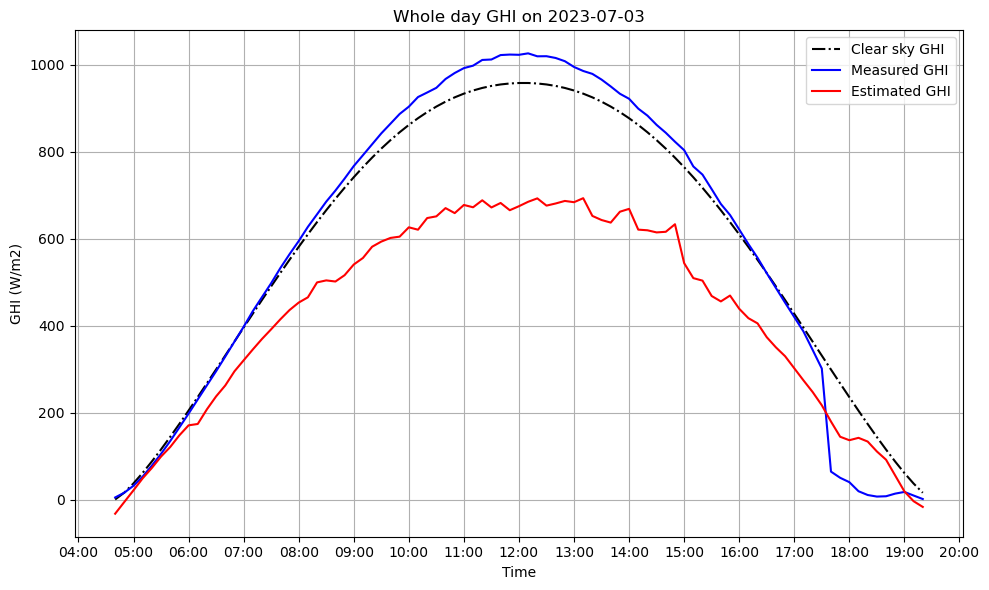

In [320]:
time_plot(c_2d,estimate_2d,display ='Show',path='')